# Multi-layer perceptron model 

Playground for predicting LMA rest-eigen contributions using simple NN architectures. 


In [186]:
using LmaPredict, Flux, PyPlot, MLUtils
using Base.Iterators: partition
using Flux.Optimise: update!
using Flux.Losses: logitbinarycrossentropy
using ADerrors


In [5]:
path_config = "/Users/alessandroconigli/Lattice/data/HVP/LMA/A654/"
path_plot="/Users/alessandroconigli/Desktop/postdoc-mainz/projects/MLtoLMA"


"/Users/alessandroconigli/Desktop/postdoc-mainz/projects/MLtoLMA"

In [3]:
fname = readdir(path_config)
idx_cut = findall(x->x<=2500 , parse.(Int64, fname))
fname = fname[idx_cut]
idx = sortperm( parse.(Int64, fname))
fname = fname[idx]

cnfgarr = Vector{LMAConfig}(undef, 0)
for f in fname
    push!(cnfgarr, get_LMAConfig(joinpath(path_config, f), "g5-g5", em="PA", bc=false))
end

In [374]:
NCNFG = length(cnfgarr)
TVALS = length(cnfgarr[1].data["rr"]["0"]) 

TSRC_rr = collect(keys(getfield(cnfgarr[1], :data)["rr"] ))
TSRC_re = collect(keys(getfield(cnfgarr[1], :data)["re"] ))
# the sources has to be the same for both rr and ee

rr_data = Array{Float64}(undef, TVALS, NCNFG, length(TSRC_rr) )
re_data = Array{Float64}(undef, TVALS, NCNFG, length(TSRC_rr) )

for t in 1:TVALS    
    for n in 1:NCNFG
        for (k,ts) in enumerate(TSRC_rr)
            
            rr_data[t,n,k] = getfield(cnfgarr[n], :data)["rr"][ts][t]
            re_data[t,n,k] = getfield(cnfgarr[n], :data)["re"][ts][t]
            
        end
    end
end

rr_data_train = rr_data[:,1:5:end,:] 
rr_data_test  = reshape(setdiff(rr_data, rr_data_train), (size(rr_data,1), size(rr_data,2)-size(rr_data_train,2), size(rr_data,3)))

re_data_train = re_data[:,1:5:end,:] 
re_data_test  = reshape(setdiff(re_data, re_data_train), (size(re_data,1), size(re_data,2)-size(re_data_train,2), size(re_data,3)));

In [375]:
mean_rr_train = mean(rr_data_train, dims=2)
mean_re_train = mean(re_data_train, dims=2)

mean_rr_test  = mean(rr_data_test, dims=2)
mean_re_test  = mean(re_data_test, dims=2)

std_rr_train = std(rr_data_train, dims=2)
std_re_train = std(re_data_train, dims=2)

std_rr_test  = std(rr_data_test, dims=2)
std_re_test  = std(re_data_test, dims=2);


In [376]:
re_data_test

48×2000×4 Array{Float64, 3}:
[:, :, 1] =
  0.0125343     0.00971383    0.0130368    …   0.00988056    0.011029
  0.00872579    0.00628504    0.00907184       0.00623014    0.00698028
  0.00694158    0.0053087     0.00813569       0.00543994    0.0058579
  0.00482595    0.00428759    0.00614869       0.00459928    0.0045645
  0.00279343    0.0031259     0.00384667       0.00351513    0.00300086
  0.00124407    0.00197883    0.00216029   …   0.00243897    0.0017445
  0.000138752   0.000890343   0.000975362      0.00139585    0.000897698
 -0.000624402  -8.38412e-6   -0.0002862        0.000378646   0.000118282
 -0.0011233    -0.000711168  -0.00135963      -0.000457287  -0.00050899
 -0.00154524   -0.00120276   -0.00221263      -0.00106189   -0.00109712
 -0.00166401   -0.00145405   -0.00276498   …  -0.00156676   -0.00172353
 -0.00171205   -0.00168788   -0.00305865      -0.00188806   -0.00210359
 -0.00177439   -0.00185211   -0.00302833      -0.00208723   -0.00237993
  ⋮                       

In [377]:
function loss(y, ypred)
    lss = Flux.mse(ypred, y)
    return lss
end

function MLP_net()
    net = Chain(
        #Dense(1=>16, leakyrelu),
        #Dense(10 => 20),
        #Dense(32 => 64, leakyrelu),
        #Dense(64 => 32, leakyrelu),
        #Dense(16 => 16, elu),
        Dense(1 =>1)
    )
    return net
end

function train_mlp!(net, x, y, hp)

    opt = Flux.setup(Adam(hp.lr), net)
    
    #ncnfg, src = size(x)
    ncnfg = size(x,1)
    
    x = reshape(x, 1, 1, 1, ncnfg)
    y = reshape(y, 1, 1, 1, ncnfg)

    xbatch = [x[:,:,:, k] for k in partition(1:size(x,4), hp.batch_size)]
    ybatch = [y[:,:,:, k] for k in partition(1:size(y,4), hp.batch_size)]

    store_lss = []
    train_steps = 0 
    for ep in 1:hp.epochs
        for k in eachindex(xbatch[1:end])

            lss, grads = Flux.withgradient(net) do net
                loss(ybatch[k], net(xbatch[k]))
            end
            update!(opt, net, grads[1])
            push!(store_lss, lss)

            if train_steps % hp.verbose_freq == 0 
                @info "Epoch $(ep): train step: $(train_steps), loss: $(lss)"
            end
            train_steps +=1
        end
    end
    plot(store_lss, label="loss")
    legend()
    display(gcf())
    close("all")
    return nothing
end

train_mlp! (generic function with 1 method)

In [378]:
## training
Base.@kwdef struct HyperParams
    batch_size::Int = 10
    epochs::Int = 1000
    verbose_freq::Int = 500
    lr::Float32 = 0.001
end

hp = HyperParams()
net_tot = [MLP_net()  for t in 1:TVALS ];


[ Info: Epoch 1: train step: 0, loss: 0.990237162491096
[ Info: Epoch 11: train step: 500, loss: 0.7836581169131274
[ Info: Epoch 21: train step: 1000, loss: 0.720674244093119
[ Info: Epoch 31: train step: 1500, loss: 0.7049743665374584
[ Info: Epoch 41: train step: 2000, loss: 0.7013200958511188
[ Info: Epoch 51: train step: 2500, loss: 0.7004551843303728
[ Info: Epoch 61: train step: 3000, loss: 0.7002556503051883
[ Info: Epoch 71: train step: 3500, loss: 0.7002124152676715
[ Info: Epoch 81: train step: 4000, loss: 0.7002037589878681
[ Info: Epoch 91: train step: 4500, loss: 0.7002022804102526
[ Info: Epoch 101: train step: 5000, loss: 0.7002021450444653
[ Info: Epoch 111: train step: 5500, loss: 0.7002022092850073
[ Info: Epoch 121: train step: 6000, loss: 0.7002022971943466
[ Info: Epoch 131: train step: 6500, loss: 0.7002023421888055
[ Info: Epoch 141: train step: 7000, loss: 0.7002023777006238
[ Info: Epoch 151: train step: 7500, loss: 0.7002023971610303
[ Info: Epoch 161: train 

[ Info: Epoch 861: train step: 43000, loss: 0.7002024480213056
[ Info: Epoch 871: train step: 43500, loss: 0.7002024480213056
[ Info: Epoch 881: train step: 44000, loss: 0.7002024480213056
[ Info: Epoch 891: train step: 44500, loss: 0.7002024480213056
[ Info: Epoch 901: train step: 45000, loss: 0.7002024480213056
[ Info: Epoch 911: train step: 45500, loss: 0.7002024480213056
[ Info: Epoch 921: train step: 46000, loss: 0.7002024480213056
[ Info: Epoch 931: train step: 46500, loss: 0.7002024480213056
[ Info: Epoch 941: train step: 47000, loss: 0.7002024480213056
[ Info: Epoch 951: train step: 47500, loss: 0.7002024480213056
[ Info: Epoch 961: train step: 48000, loss: 0.7002024480213056
[ Info: Epoch 971: train step: 48500, loss: 0.7002024480213056
[ Info: Epoch 981: train step: 49000, loss: 0.7002024480213056
[ Info: Epoch 991: train step: 49500, loss: 0.7002024480213056


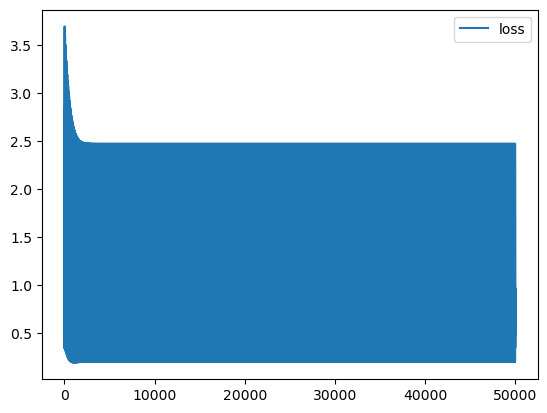

[ Info: Epoch 1: train step: 0, loss: 1.3427576410308582
[ Info: Epoch 11: train step: 500, loss: 0.8916821675678746
[ Info: Epoch 21: train step: 1000, loss: 0.6485008836249465
[ Info: Epoch 31: train step: 1500, loss: 0.5341546835941064
[ Info: Epoch 41: train step: 2000, loss: 0.4920663563101904
[ Info: Epoch 51: train step: 2500, loss: 0.4822684876495865
[ Info: Epoch 61: train step: 3000, loss: 0.48227299278585684
[ Info: Epoch 71: train step: 3500, loss: 0.48343356531240483
[ Info: Epoch 81: train step: 4000, loss: 0.48403549458182055
[ Info: Epoch 91: train step: 4500, loss: 0.48424048397365915
[ Info: Epoch 101: train step: 5000, loss: 0.4842975984785166
[ Info: Epoch 111: train step: 5500, loss: 0.4843121274969991
[ Info: Epoch 121: train step: 6000, loss: 0.48431590812986514
[ Info: Epoch 131: train step: 6500, loss: 0.48431705436674494
[ Info: Epoch 141: train step: 7000, loss: 0.48431750268160634
[ Info: Epoch 151: train step: 7500, loss: 0.48431773172880244
[ Info: Epoch 1

[ Info: Epoch 821: train step: 41000, loss: 0.48431800502063604
[ Info: Epoch 831: train step: 41500, loss: 0.48431800502063604
[ Info: Epoch 841: train step: 42000, loss: 0.48431800502063604
[ Info: Epoch 851: train step: 42500, loss: 0.48431800502063604
[ Info: Epoch 861: train step: 43000, loss: 0.48431800502063604
[ Info: Epoch 871: train step: 43500, loss: 0.48431800502063604
[ Info: Epoch 881: train step: 44000, loss: 0.48431800502063604
[ Info: Epoch 891: train step: 44500, loss: 0.48431800502063604
[ Info: Epoch 901: train step: 45000, loss: 0.48431800502063604
[ Info: Epoch 911: train step: 45500, loss: 0.48431800502063604
[ Info: Epoch 921: train step: 46000, loss: 0.48431800502063604
[ Info: Epoch 931: train step: 46500, loss: 0.48431800502063604
[ Info: Epoch 941: train step: 47000, loss: 0.48431800502063604
[ Info: Epoch 951: train step: 47500, loss: 0.48431800502063604
[ Info: Epoch 961: train step: 48000, loss: 0.48431800502063604
[ Info: Epoch 971: train step: 48500, lo

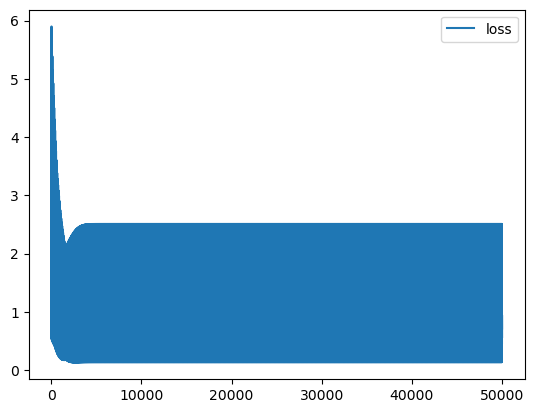

[ Info: Epoch 1: train step: 0, loss: 1.357361535890655
[ Info: Epoch 11: train step: 500, loss: 0.9316414309046219
[ Info: Epoch 21: train step: 1000, loss: 0.7188239537160376
[ Info: Epoch 31: train step: 1500, loss: 0.6259247572606075
[ Info: Epoch 41: train step: 2000, loss: 0.5908822747189033
[ Info: Epoch 51: train step: 2500, loss: 0.5791567841524314
[ Info: Epoch 61: train step: 3000, loss: 0.5756694824127662
[ Info: Epoch 71: train step: 3500, loss: 0.5747742672664011
[ Info: Epoch 81: train step: 4000, loss: 0.5745782346566519
[ Info: Epoch 91: train step: 4500, loss: 0.5745411947958549
[ Info: Epoch 101: train step: 5000, loss: 0.5745352155059281
[ Info: Epoch 111: train step: 5500, loss: 0.5745345260936638
[ Info: Epoch 121: train step: 6000, loss: 0.57453460052132
[ Info: Epoch 131: train step: 6500, loss: 0.5745347041405161
[ Info: Epoch 141: train step: 7000, loss: 0.5745348012768647
[ Info: Epoch 151: train step: 7500, loss: 0.5745348325190773
[ Info: Epoch 161: train s

[ Info: Epoch 881: train step: 44000, loss: 0.5745349122197435
[ Info: Epoch 891: train step: 44500, loss: 0.5745349122559972
[ Info: Epoch 901: train step: 45000, loss: 0.5745349121783109
[ Info: Epoch 911: train step: 45500, loss: 0.5745349122197435
[ Info: Epoch 921: train step: 46000, loss: 0.5745349122559972
[ Info: Epoch 931: train step: 46500, loss: 0.5745349121783109
[ Info: Epoch 941: train step: 47000, loss: 0.5745349122197435
[ Info: Epoch 951: train step: 47500, loss: 0.5745349122559972
[ Info: Epoch 961: train step: 48000, loss: 0.5745349121783109
[ Info: Epoch 971: train step: 48500, loss: 0.5745349122197435
[ Info: Epoch 981: train step: 49000, loss: 0.5745349122559972
[ Info: Epoch 991: train step: 49500, loss: 0.5745349121783109


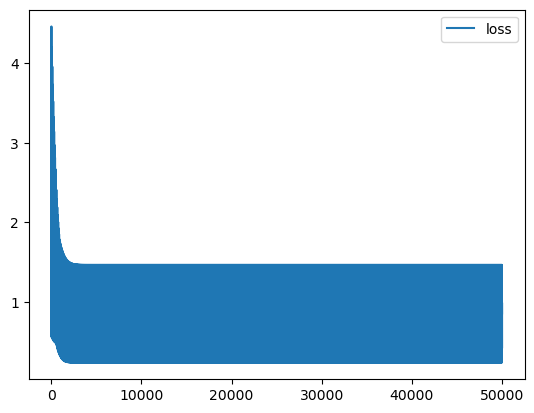

[ Info: Epoch 1: train step: 0, loss: 2.7959710439711807
[ Info: Epoch 11: train step: 500, loss: 1.9999263485477017
[ Info: Epoch 21: train step: 1000, loss: 1.4775066940747537
[ Info: Epoch 31: train step: 1500, loss: 1.157727367693932
[ Info: Epoch 41: train step: 2000, loss: 0.979908386044728
[ Info: Epoch 51: train step: 2500, loss: 0.8930791944931666
[ Info: Epoch 61: train step: 3000, loss: 0.8570032812180013
[ Info: Epoch 71: train step: 3500, loss: 0.8443437918256051
[ Info: Epoch 81: train step: 4000, loss: 0.8404270229690237
[ Info: Epoch 91: train step: 4500, loss: 0.8392814112512447
[ Info: Epoch 101: train step: 5000, loss: 0.83896166067862
[ Info: Epoch 111: train step: 5500, loss: 0.8388807460305292
[ Info: Epoch 121: train step: 6000, loss: 0.8388627204950014
[ Info: Epoch 131: train step: 6500, loss: 0.8388591691142079
[ Info: Epoch 141: train step: 7000, loss: 0.8388585417213511
[ Info: Epoch 151: train step: 7500, loss: 0.8388584626487203
[ Info: Epoch 161: train st

[ Info: Epoch 841: train step: 42000, loss: 0.8388585014891884
[ Info: Epoch 851: train step: 42500, loss: 0.8388585014891884
[ Info: Epoch 861: train step: 43000, loss: 0.8388585014891884
[ Info: Epoch 871: train step: 43500, loss: 0.8388585014891884
[ Info: Epoch 881: train step: 44000, loss: 0.8388585014891884
[ Info: Epoch 891: train step: 44500, loss: 0.8388585014891884
[ Info: Epoch 901: train step: 45000, loss: 0.8388585014891884
[ Info: Epoch 911: train step: 45500, loss: 0.8388585014891884
[ Info: Epoch 921: train step: 46000, loss: 0.8388585014891884
[ Info: Epoch 931: train step: 46500, loss: 0.8388585014891884
[ Info: Epoch 941: train step: 47000, loss: 0.8388585014891884
[ Info: Epoch 951: train step: 47500, loss: 0.8388585014891884
[ Info: Epoch 961: train step: 48000, loss: 0.8388585014891884
[ Info: Epoch 971: train step: 48500, loss: 0.8388585014891884
[ Info: Epoch 981: train step: 49000, loss: 0.8388585014891884
[ Info: Epoch 991: train step: 49500, loss: 0.838858501

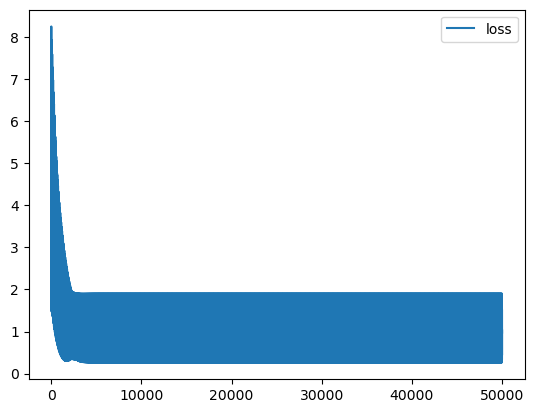

[ Info: Epoch 1: train step: 0, loss: 2.664072221010475
[ Info: Epoch 11: train step: 500, loss: 1.9170172684215259
[ Info: Epoch 21: train step: 1000, loss: 1.4750907613098856
[ Info: Epoch 31: train step: 1500, loss: 1.2384718913600528
[ Info: Epoch 41: train step: 2000, loss: 1.1253120060419723
[ Info: Epoch 51: train step: 2500, loss: 1.0769896672107437
[ Info: Epoch 61: train step: 3000, loss: 1.0583074227700928
[ Info: Epoch 71: train step: 3500, loss: 1.0517755953233299
[ Info: Epoch 81: train step: 4000, loss: 1.0497536728689572
[ Info: Epoch 91: train step: 4500, loss: 1.0492027882440143
[ Info: Epoch 101: train step: 5000, loss: 1.049066021156248
[ Info: Epoch 111: train step: 5500, loss: 1.0490322609158298
[ Info: Epoch 121: train step: 6000, loss: 1.0490226190438943
[ Info: Epoch 131: train step: 6500, loss: 1.04901899344435
[ Info: Epoch 141: train step: 7000, loss: 1.0490171873954766
[ Info: Epoch 151: train step: 7500, loss: 1.0490161581988338
[ Info: Epoch 161: train st

[ Info: Epoch 881: train step: 44000, loss: 1.049014710204983
[ Info: Epoch 891: train step: 44500, loss: 1.0490147102570355
[ Info: Epoch 901: train step: 45000, loss: 1.049014710283062
[ Info: Epoch 911: train step: 45500, loss: 1.049014710204983
[ Info: Epoch 921: train step: 46000, loss: 1.0490147102570355
[ Info: Epoch 931: train step: 46500, loss: 1.049014710283062
[ Info: Epoch 941: train step: 47000, loss: 1.049014710204983
[ Info: Epoch 951: train step: 47500, loss: 1.0490147102570355
[ Info: Epoch 961: train step: 48000, loss: 1.049014710283062
[ Info: Epoch 971: train step: 48500, loss: 1.049014710204983
[ Info: Epoch 981: train step: 49000, loss: 1.0490147102570355
[ Info: Epoch 991: train step: 49500, loss: 1.049014710283062


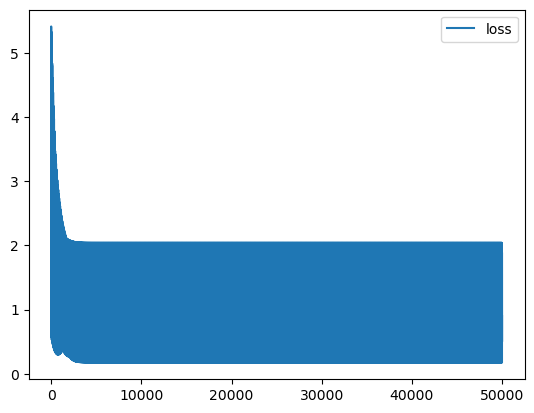

[ Info: Epoch 1: train step: 0, loss: 1.5930319628495966
[ Info: Epoch 11: train step: 500, loss: 1.175681568561353
[ Info: Epoch 21: train step: 1000, loss: 1.0098810245826315
[ Info: Epoch 31: train step: 1500, loss: 0.9558151601458242
[ Info: Epoch 41: train step: 2000, loss: 0.9402156730849403
[ Info: Epoch 51: train step: 2500, loss: 0.9359425909245989
[ Info: Epoch 61: train step: 3000, loss: 0.9348393298689626
[ Info: Epoch 71: train step: 3500, loss: 0.9345745232113079
[ Info: Epoch 81: train step: 4000, loss: 0.9345133866624165
[ Info: Epoch 91: train step: 4500, loss: 0.9344984801685534
[ Info: Epoch 101: train step: 5000, loss: 0.9344940401181845
[ Info: Epoch 111: train step: 5500, loss: 0.9344922528714109
[ Info: Epoch 121: train step: 6000, loss: 0.9344913366585221
[ Info: Epoch 131: train step: 6500, loss: 0.9344908114196719
[ Info: Epoch 141: train step: 7000, loss: 0.9344905033564606
[ Info: Epoch 151: train step: 7500, loss: 0.9344903126009758
[ Info: Epoch 161: train

[ Info: Epoch 861: train step: 43000, loss: 0.934490045519173
[ Info: Epoch 871: train step: 43500, loss: 0.934490045519173
[ Info: Epoch 881: train step: 44000, loss: 0.934490045519173
[ Info: Epoch 891: train step: 44500, loss: 0.934490045519173
[ Info: Epoch 901: train step: 45000, loss: 0.934490045519173
[ Info: Epoch 911: train step: 45500, loss: 0.934490045519173
[ Info: Epoch 921: train step: 46000, loss: 0.934490045519173
[ Info: Epoch 931: train step: 46500, loss: 0.934490045519173
[ Info: Epoch 941: train step: 47000, loss: 0.934490045519173
[ Info: Epoch 951: train step: 47500, loss: 0.934490045519173
[ Info: Epoch 961: train step: 48000, loss: 0.934490045519173
[ Info: Epoch 971: train step: 48500, loss: 0.934490045519173
[ Info: Epoch 981: train step: 49000, loss: 0.934490045519173
[ Info: Epoch 991: train step: 49500, loss: 0.934490045519173


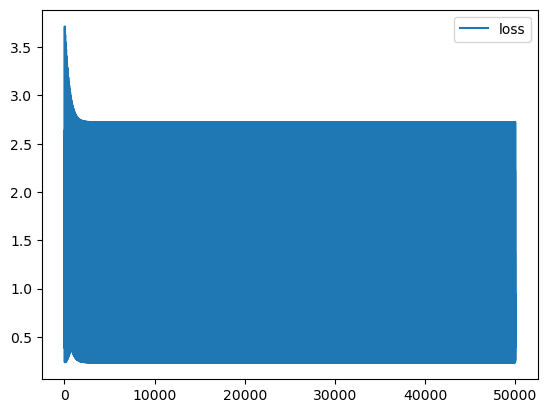

[ Info: Epoch 1: train step: 0, loss: 2.580471743864723
[ Info: Epoch 11: train step: 500, loss: 1.7497667127502854
[ Info: Epoch 21: train step: 1000, loss: 1.233796220681801
[ Info: Epoch 31: train step: 1500, loss: 0.9408930354110963
[ Info: Epoch 41: train step: 2000, loss: 0.793882855667877
[ Info: Epoch 51: train step: 2500, loss: 0.7310934637464277
[ Info: Epoch 61: train step: 3000, loss: 0.708816819019974
[ Info: Epoch 71: train step: 3500, loss: 0.7021028039935235
[ Info: Epoch 81: train step: 4000, loss: 0.7002407311199615
[ Info: Epoch 91: train step: 4500, loss: 0.6997379355537457
[ Info: Epoch 101: train step: 5000, loss: 0.6996117427966672
[ Info: Epoch 111: train step: 5500, loss: 0.699585403564386
[ Info: Epoch 121: train step: 6000, loss: 0.6995822112044217
[ Info: Epoch 131: train step: 6500, loss: 0.6995831890916516
[ Info: Epoch 141: train step: 7000, loss: 0.6995844006699704
[ Info: Epoch 151: train step: 7500, loss: 0.6995852665013246
[ Info: Epoch 161: train ste

[ Info: Epoch 841: train step: 42000, loss: 0.6995866984495249
[ Info: Epoch 851: train step: 42500, loss: 0.6995866984694729
[ Info: Epoch 861: train step: 43000, loss: 0.6995866984495249
[ Info: Epoch 871: train step: 43500, loss: 0.6995866984694729
[ Info: Epoch 881: train step: 44000, loss: 0.6995866984495249
[ Info: Epoch 891: train step: 44500, loss: 0.6995866984694729
[ Info: Epoch 901: train step: 45000, loss: 0.6995866984495249
[ Info: Epoch 911: train step: 45500, loss: 0.6995866984694729
[ Info: Epoch 921: train step: 46000, loss: 0.6995866984495249
[ Info: Epoch 931: train step: 46500, loss: 0.6995866984694729
[ Info: Epoch 941: train step: 47000, loss: 0.6995866984495249
[ Info: Epoch 951: train step: 47500, loss: 0.6995866984694729
[ Info: Epoch 961: train step: 48000, loss: 0.6995866984495249
[ Info: Epoch 971: train step: 48500, loss: 0.6995866984694729
[ Info: Epoch 981: train step: 49000, loss: 0.6995866984495249
[ Info: Epoch 991: train step: 49500, loss: 0.699586698

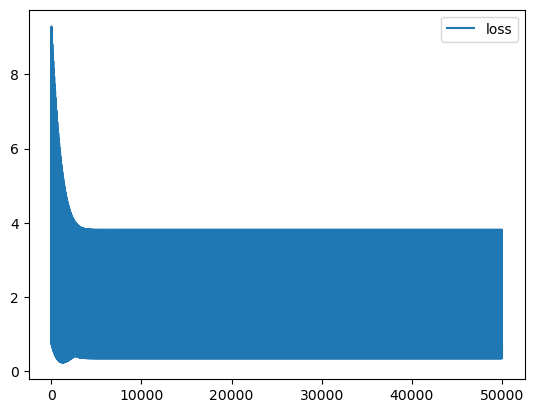

[ Info: Epoch 1: train step: 0, loss: 0.5193135354407212
[ Info: Epoch 11: train step: 500, loss: 0.4546670490945376
[ Info: Epoch 21: train step: 1000, loss: 0.4526975343049882
[ Info: Epoch 31: train step: 1500, loss: 0.4532044159810611
[ Info: Epoch 41: train step: 2000, loss: 0.453316722257956
[ Info: Epoch 51: train step: 2500, loss: 0.4533351935051111
[ Info: Epoch 61: train step: 3000, loss: 0.4533384133824379
[ Info: Epoch 71: train step: 3500, loss: 0.45333917330053675
[ Info: Epoch 81: train step: 4000, loss: 0.4533394532839047
[ Info: Epoch 91: train step: 4500, loss: 0.45333959883543906
[ Info: Epoch 101: train step: 5000, loss: 0.45333967876581066
[ Info: Epoch 111: train step: 5500, loss: 0.45333972457381966
[ Info: Epoch 121: train step: 6000, loss: 0.4533397547771525
[ Info: Epoch 131: train step: 6500, loss: 0.4533397715962205
[ Info: Epoch 141: train step: 7000, loss: 0.4533397830142075
[ Info: Epoch 151: train step: 7500, loss: 0.4533397895717878
[ Info: Epoch 161: t

[ Info: Epoch 821: train step: 41000, loss: 0.45333979356527127
[ Info: Epoch 831: train step: 41500, loss: 0.45333979356527127
[ Info: Epoch 841: train step: 42000, loss: 0.45333979356527127
[ Info: Epoch 851: train step: 42500, loss: 0.45333979356527127
[ Info: Epoch 861: train step: 43000, loss: 0.45333979356527127
[ Info: Epoch 871: train step: 43500, loss: 0.45333979356527127
[ Info: Epoch 881: train step: 44000, loss: 0.45333979356527127
[ Info: Epoch 891: train step: 44500, loss: 0.45333979356527127
[ Info: Epoch 901: train step: 45000, loss: 0.45333979356527127
[ Info: Epoch 911: train step: 45500, loss: 0.45333979356527127
[ Info: Epoch 921: train step: 46000, loss: 0.45333979356527127
[ Info: Epoch 931: train step: 46500, loss: 0.45333979356527127
[ Info: Epoch 941: train step: 47000, loss: 0.45333979356527127
[ Info: Epoch 951: train step: 47500, loss: 0.45333979356527127
[ Info: Epoch 961: train step: 48000, loss: 0.45333979356527127
[ Info: Epoch 971: train step: 48500, lo

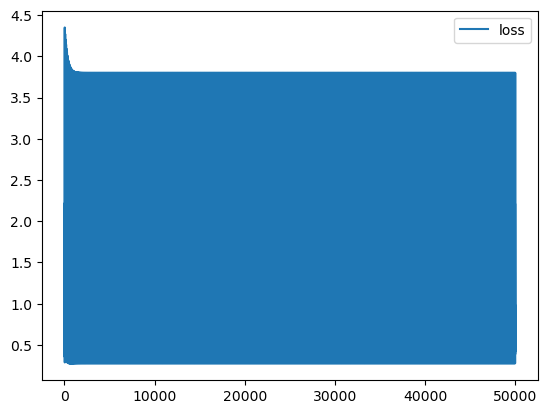

[ Info: Epoch 1: train step: 0, loss: 0.5971371483390425
[ Info: Epoch 11: train step: 500, loss: 0.398746595818665
[ Info: Epoch 21: train step: 1000, loss: 0.35466429385185816
[ Info: Epoch 31: train step: 1500, loss: 0.34628413941179315
[ Info: Epoch 41: train step: 2000, loss: 0.3446555384123571
[ Info: Epoch 51: train step: 2500, loss: 0.3443406673060587
[ Info: Epoch 61: train step: 3000, loss: 0.3442816323892219
[ Info: Epoch 71: train step: 3500, loss: 0.3442701820453495
[ Info: Epoch 81: train step: 4000, loss: 0.3442674676430476
[ Info: Epoch 91: train step: 4500, loss: 0.3442665369779716
[ Info: Epoch 101: train step: 5000, loss: 0.34426607558569894
[ Info: Epoch 111: train step: 5500, loss: 0.3442658260386976
[ Info: Epoch 121: train step: 6000, loss: 0.34426567243840217
[ Info: Epoch 131: train step: 6500, loss: 0.34426557750573233
[ Info: Epoch 141: train step: 7000, loss: 0.34426552624000145
[ Info: Epoch 151: train step: 7500, loss: 0.34426548299365173
[ Info: Epoch 161

[ Info: Epoch 821: train step: 41000, loss: 0.3442654436898453
[ Info: Epoch 831: train step: 41500, loss: 0.3442654436898453
[ Info: Epoch 841: train step: 42000, loss: 0.3442654436898453
[ Info: Epoch 851: train step: 42500, loss: 0.3442654436898453
[ Info: Epoch 861: train step: 43000, loss: 0.3442654436898453
[ Info: Epoch 871: train step: 43500, loss: 0.3442654436898453
[ Info: Epoch 881: train step: 44000, loss: 0.3442654436898453
[ Info: Epoch 891: train step: 44500, loss: 0.3442654436898453
[ Info: Epoch 901: train step: 45000, loss: 0.3442654436898453
[ Info: Epoch 911: train step: 45500, loss: 0.3442654436898453
[ Info: Epoch 921: train step: 46000, loss: 0.3442654436898453
[ Info: Epoch 931: train step: 46500, loss: 0.3442654436898453
[ Info: Epoch 941: train step: 47000, loss: 0.3442654436898453
[ Info: Epoch 951: train step: 47500, loss: 0.3442654436898453
[ Info: Epoch 961: train step: 48000, loss: 0.3442654436898453
[ Info: Epoch 971: train step: 48500, loss: 0.344265443

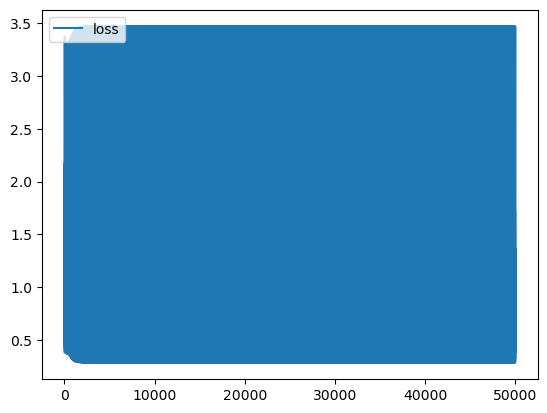

[ Info: Epoch 1: train step: 0, loss: 0.627004582900081
[ Info: Epoch 11: train step: 500, loss: 0.368175355812977
[ Info: Epoch 21: train step: 1000, loss: 0.31641969582836643
[ Info: Epoch 31: train step: 1500, loss: 0.3152335903257185
[ Info: Epoch 41: train step: 2000, loss: 0.3177668930724755
[ Info: Epoch 51: train step: 2500, loss: 0.31871263762194163
[ Info: Epoch 61: train step: 3000, loss: 0.31894865712049486
[ Info: Epoch 71: train step: 3500, loss: 0.3189970806037811
[ Info: Epoch 81: train step: 4000, loss: 0.3190047441727872
[ Info: Epoch 91: train step: 4500, loss: 0.31900482632210403
[ Info: Epoch 101: train step: 5000, loss: 0.3190039526039402
[ Info: Epoch 111: train step: 5500, loss: 0.3190032592648408
[ Info: Epoch 121: train step: 6000, loss: 0.3190027950671267
[ Info: Epoch 131: train step: 6500, loss: 0.3190025084639542
[ Info: Epoch 141: train step: 7000, loss: 0.3190023289059093
[ Info: Epoch 151: train step: 7500, loss: 0.3190022066496264
[ Info: Epoch 161: tr

[ Info: Epoch 821: train step: 41000, loss: 0.31900201322404287
[ Info: Epoch 831: train step: 41500, loss: 0.31900201322404287
[ Info: Epoch 841: train step: 42000, loss: 0.31900201322404287
[ Info: Epoch 851: train step: 42500, loss: 0.31900201322404287
[ Info: Epoch 861: train step: 43000, loss: 0.31900201322404287
[ Info: Epoch 871: train step: 43500, loss: 0.31900201322404287
[ Info: Epoch 881: train step: 44000, loss: 0.31900201322404287
[ Info: Epoch 891: train step: 44500, loss: 0.31900201322404287
[ Info: Epoch 901: train step: 45000, loss: 0.31900201322404287
[ Info: Epoch 911: train step: 45500, loss: 0.31900201322404287
[ Info: Epoch 921: train step: 46000, loss: 0.31900201322404287
[ Info: Epoch 931: train step: 46500, loss: 0.31900201322404287
[ Info: Epoch 941: train step: 47000, loss: 0.31900201322404287
[ Info: Epoch 951: train step: 47500, loss: 0.31900201322404287
[ Info: Epoch 961: train step: 48000, loss: 0.31900201322404287
[ Info: Epoch 971: train step: 48500, lo

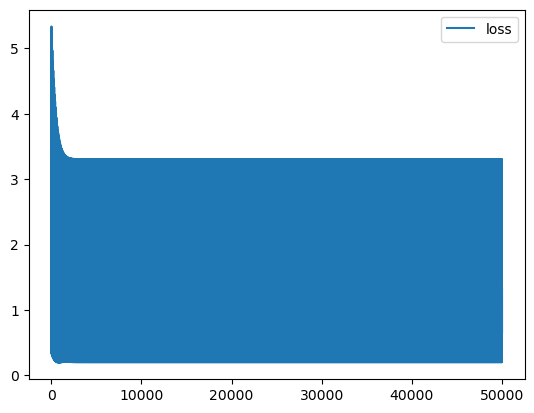

[ Info: Epoch 1: train step: 0, loss: 1.5542865215066748
[ Info: Epoch 11: train step: 500, loss: 0.8875939672923326
[ Info: Epoch 21: train step: 1000, loss: 0.5616082726547189
[ Info: Epoch 31: train step: 1500, loss: 0.42769973010369694
[ Info: Epoch 41: train step: 2000, loss: 0.3865322936605979
[ Info: Epoch 51: train step: 2500, loss: 0.37861739774577086
[ Info: Epoch 61: train step: 3000, loss: 0.3783500392112093
[ Info: Epoch 71: train step: 3500, loss: 0.37876651215968304
[ Info: Epoch 81: train step: 4000, loss: 0.37895285807661216
[ Info: Epoch 91: train step: 4500, loss: 0.37900709115078496
[ Info: Epoch 101: train step: 5000, loss: 0.37901968105576894
[ Info: Epoch 111: train step: 5500, loss: 0.37902184131698213
[ Info: Epoch 121: train step: 6000, loss: 0.37902178946757703
[ Info: Epoch 131: train step: 6500, loss: 0.3790214386543466
[ Info: Epoch 141: train step: 7000, loss: 0.37902115681939436
[ Info: Epoch 151: train step: 7500, loss: 0.3790209747891447
[ Info: Epoch 

[ Info: Epoch 861: train step: 43000, loss: 0.37902067317964716
[ Info: Epoch 871: train step: 43500, loss: 0.37902067317964716
[ Info: Epoch 881: train step: 44000, loss: 0.37902067317964716
[ Info: Epoch 891: train step: 44500, loss: 0.37902067317964716
[ Info: Epoch 901: train step: 45000, loss: 0.37902067317964716
[ Info: Epoch 911: train step: 45500, loss: 0.37902067317964716
[ Info: Epoch 921: train step: 46000, loss: 0.37902067317964716
[ Info: Epoch 931: train step: 46500, loss: 0.37902067317964716
[ Info: Epoch 941: train step: 47000, loss: 0.37902067317964716
[ Info: Epoch 951: train step: 47500, loss: 0.37902067317964716
[ Info: Epoch 961: train step: 48000, loss: 0.37902067317964716
[ Info: Epoch 971: train step: 48500, loss: 0.37902067317964716
[ Info: Epoch 981: train step: 49000, loss: 0.37902067317964716
[ Info: Epoch 991: train step: 49500, loss: 0.37902067317964716


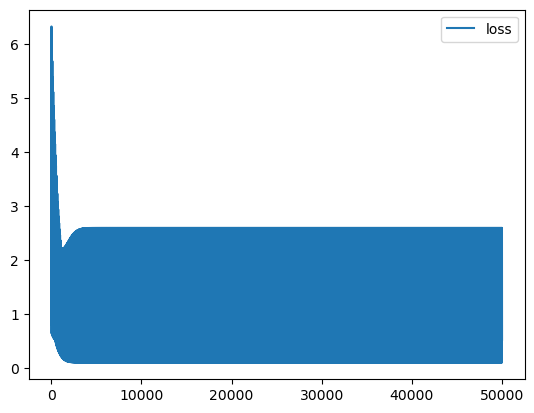

[ Info: Epoch 1: train step: 0, loss: 1.3983869466501624
[ Info: Epoch 11: train step: 500, loss: 0.771954309299079
[ Info: Epoch 21: train step: 1000, loss: 0.499168181732849
[ Info: Epoch 31: train step: 1500, loss: 0.3977533609359804
[ Info: Epoch 41: train step: 2000, loss: 0.36473833198949135
[ Info: Epoch 51: train step: 2500, loss: 0.3548801844938191
[ Info: Epoch 61: train step: 3000, loss: 0.3521951731997855
[ Info: Epoch 71: train step: 3500, loss: 0.3515429988889617
[ Info: Epoch 81: train step: 4000, loss: 0.35140510241849043
[ Info: Epoch 91: train step: 4500, loss: 0.35138266333074303
[ Info: Epoch 101: train step: 5000, loss: 0.3513823799951348
[ Info: Epoch 111: train step: 5500, loss: 0.35138518329623836
[ Info: Epoch 121: train step: 6000, loss: 0.35138740067906654
[ Info: Epoch 131: train step: 6500, loss: 0.35138886170033323
[ Info: Epoch 141: train step: 7000, loss: 0.35138965624036467
[ Info: Epoch 151: train step: 7500, loss: 0.3513901799053416
[ Info: Epoch 161:

[ Info: Epoch 861: train step: 43000, loss: 0.3513910532213419
[ Info: Epoch 871: train step: 43500, loss: 0.35139105307164065
[ Info: Epoch 881: train step: 44000, loss: 0.3513910532213419
[ Info: Epoch 891: train step: 44500, loss: 0.35139105307164065
[ Info: Epoch 901: train step: 45000, loss: 0.3513910532213419
[ Info: Epoch 911: train step: 45500, loss: 0.35139105307164065
[ Info: Epoch 921: train step: 46000, loss: 0.3513910532213419
[ Info: Epoch 931: train step: 46500, loss: 0.35139105307164065
[ Info: Epoch 941: train step: 47000, loss: 0.3513910532213419
[ Info: Epoch 951: train step: 47500, loss: 0.35139105307164065
[ Info: Epoch 961: train step: 48000, loss: 0.3513910532213419
[ Info: Epoch 971: train step: 48500, loss: 0.35139105307164065
[ Info: Epoch 981: train step: 49000, loss: 0.3513910532213419
[ Info: Epoch 991: train step: 49500, loss: 0.35139105307164065


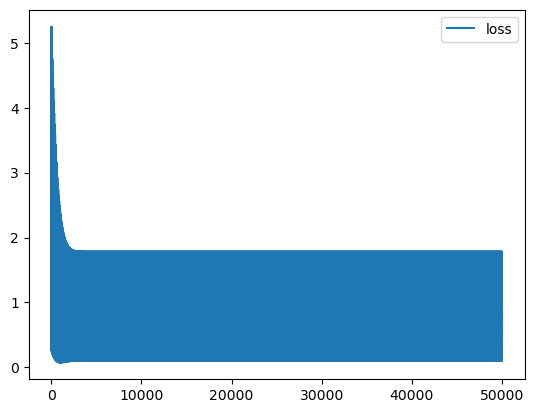

[ Info: Epoch 1: train step: 0, loss: 0.42099988717610576
[ Info: Epoch 11: train step: 500, loss: 0.26550267463274774
[ Info: Epoch 21: train step: 1000, loss: 0.3135572875005569
[ Info: Epoch 31: train step: 1500, loss: 0.38358852293686063
[ Info: Epoch 41: train step: 2000, loss: 0.42071471067035676
[ Info: Epoch 51: train step: 2500, loss: 0.4335625636966841
[ Info: Epoch 61: train step: 3000, loss: 0.4370014146492206
[ Info: Epoch 71: train step: 3500, loss: 0.43779641144656367
[ Info: Epoch 81: train step: 4000, loss: 0.4379740168739782
[ Info: Epoch 91: train step: 4500, loss: 0.4380191636780655
[ Info: Epoch 101: train step: 5000, loss: 0.43803494918319413
[ Info: Epoch 111: train step: 5500, loss: 0.4380426833236696
[ Info: Epoch 121: train step: 6000, loss: 0.43804690990489925
[ Info: Epoch 131: train step: 6500, loss: 0.4380497681379403
[ Info: Epoch 141: train step: 7000, loss: 0.43805112179116434
[ Info: Epoch 151: train step: 7500, loss: 0.43805217850614053
[ Info: Epoch 

[ Info: Epoch 841: train step: 42000, loss: 0.4380531443405046
[ Info: Epoch 851: train step: 42500, loss: 0.43805314443705806
[ Info: Epoch 861: train step: 43000, loss: 0.4380531442922278
[ Info: Epoch 871: train step: 43500, loss: 0.4380531443405046
[ Info: Epoch 881: train step: 44000, loss: 0.43805314443705806
[ Info: Epoch 891: train step: 44500, loss: 0.4380531442922278
[ Info: Epoch 901: train step: 45000, loss: 0.4380531443405046
[ Info: Epoch 911: train step: 45500, loss: 0.43805314443705806
[ Info: Epoch 921: train step: 46000, loss: 0.4380531442922278
[ Info: Epoch 931: train step: 46500, loss: 0.4380531443405046
[ Info: Epoch 941: train step: 47000, loss: 0.43805314443705806
[ Info: Epoch 951: train step: 47500, loss: 0.4380531442922278
[ Info: Epoch 961: train step: 48000, loss: 0.4380531443405046
[ Info: Epoch 971: train step: 48500, loss: 0.43805314443705806
[ Info: Epoch 981: train step: 49000, loss: 0.4380531442922278
[ Info: Epoch 991: train step: 49500, loss: 0.4380

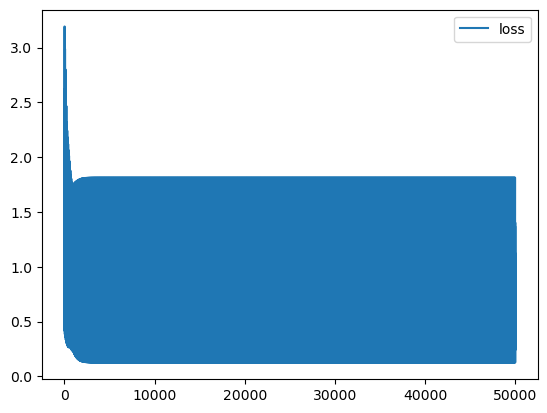

[ Info: Epoch 1: train step: 0, loss: 0.2970325763196179
[ Info: Epoch 11: train step: 500, loss: 0.35251699746685233
[ Info: Epoch 21: train step: 1000, loss: 0.48744454745512333
[ Info: Epoch 31: train step: 1500, loss: 0.557942470991558
[ Info: Epoch 41: train step: 2000, loss: 0.5801046490509225
[ Info: Epoch 51: train step: 2500, loss: 0.585405523057305
[ Info: Epoch 61: train step: 3000, loss: 0.5865042809992747
[ Info: Epoch 71: train step: 3500, loss: 0.5867226141895475
[ Info: Epoch 81: train step: 4000, loss: 0.5867701106687748
[ Info: Epoch 91: train step: 4500, loss: 0.5867841687833393
[ Info: Epoch 101: train step: 5000, loss: 0.586790023012105
[ Info: Epoch 111: train step: 5500, loss: 0.5867929839478021
[ Info: Epoch 121: train step: 6000, loss: 0.5867944337800547
[ Info: Epoch 131: train step: 6500, loss: 0.5867959647033515
[ Info: Epoch 141: train step: 7000, loss: 0.5867967060707413
[ Info: Epoch 151: train step: 7500, loss: 0.5867973562916802
[ Info: Epoch 161: train

[ Info: Epoch 841: train step: 42000, loss: 0.5867973667380239
[ Info: Epoch 851: train step: 42500, loss: 0.5867973661656755
[ Info: Epoch 861: train step: 43000, loss: 0.5867973665090844
[ Info: Epoch 871: train step: 43500, loss: 0.5867973667380239
[ Info: Epoch 881: train step: 44000, loss: 0.5867973661656755
[ Info: Epoch 891: train step: 44500, loss: 0.5867973665090844
[ Info: Epoch 901: train step: 45000, loss: 0.5867973667380239
[ Info: Epoch 911: train step: 45500, loss: 0.5867973661656755
[ Info: Epoch 921: train step: 46000, loss: 0.5867973665090844
[ Info: Epoch 931: train step: 46500, loss: 0.5867973667380239
[ Info: Epoch 941: train step: 47000, loss: 0.5867973661656755
[ Info: Epoch 951: train step: 47500, loss: 0.5867973665090844
[ Info: Epoch 961: train step: 48000, loss: 0.5867973667380239
[ Info: Epoch 971: train step: 48500, loss: 0.5867973661656755
[ Info: Epoch 981: train step: 49000, loss: 0.5867973665090844
[ Info: Epoch 991: train step: 49500, loss: 0.586797366

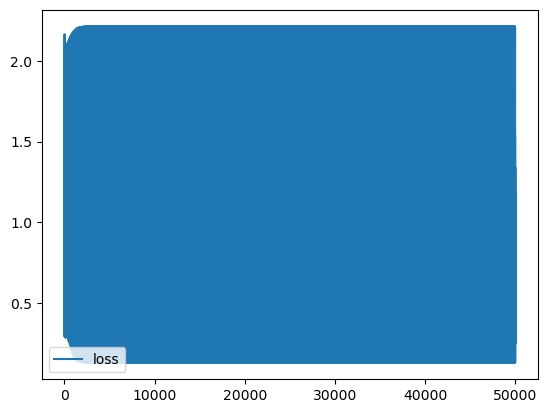

[ Info: Epoch 1: train step: 0, loss: 0.33872248392450394
[ Info: Epoch 11: train step: 500, loss: 0.3675377113540893
[ Info: Epoch 21: train step: 1000, loss: 0.523422613944628
[ Info: Epoch 31: train step: 1500, loss: 0.6104272021548833
[ Info: Epoch 41: train step: 2000, loss: 0.6380161960957726
[ Info: Epoch 51: train step: 2500, loss: 0.6444488958050646
[ Info: Epoch 61: train step: 3000, loss: 0.6457266253734573
[ Info: Epoch 71: train step: 3500, loss: 0.6459735858341045
[ Info: Epoch 81: train step: 4000, loss: 0.6460301177285432
[ Info: Epoch 91: train step: 4500, loss: 0.646049013149875
[ Info: Epoch 101: train step: 5000, loss: 0.6460587708396562
[ Info: Epoch 111: train step: 5500, loss: 0.646063713071888
[ Info: Epoch 121: train step: 6000, loss: 0.6460676498375418
[ Info: Epoch 131: train step: 6500, loss: 0.6460695213867169
[ Info: Epoch 141: train step: 7000, loss: 0.6460705928477403
[ Info: Epoch 151: train step: 7500, loss: 0.6460714031778768
[ Info: Epoch 161: train 

[ Info: Epoch 861: train step: 43000, loss: 0.6460728236860844
[ Info: Epoch 871: train step: 43500, loss: 0.6460728236860844
[ Info: Epoch 881: train step: 44000, loss: 0.6460728236860844
[ Info: Epoch 891: train step: 44500, loss: 0.6460728236860844
[ Info: Epoch 901: train step: 45000, loss: 0.6460728236860844
[ Info: Epoch 911: train step: 45500, loss: 0.6460728236860844
[ Info: Epoch 921: train step: 46000, loss: 0.6460728236860844
[ Info: Epoch 931: train step: 46500, loss: 0.6460728236860844
[ Info: Epoch 941: train step: 47000, loss: 0.6460728236860844
[ Info: Epoch 951: train step: 47500, loss: 0.6460728236860844
[ Info: Epoch 961: train step: 48000, loss: 0.6460728236860844
[ Info: Epoch 971: train step: 48500, loss: 0.6460728236860844
[ Info: Epoch 981: train step: 49000, loss: 0.6460728236860844
[ Info: Epoch 991: train step: 49500, loss: 0.6460728236860844


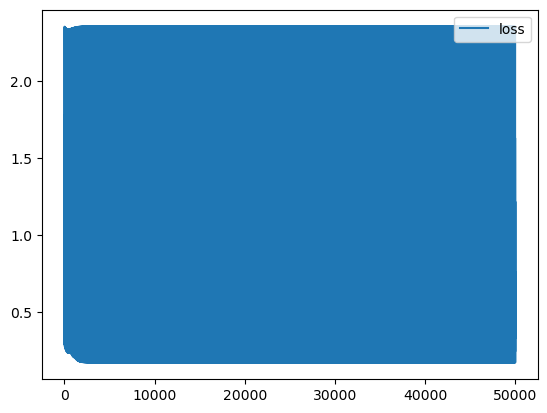

[ Info: Epoch 1: train step: 0, loss: 0.6236272911216308
[ Info: Epoch 11: train step: 500, loss: 0.2985676258983373
[ Info: Epoch 21: train step: 1000, loss: 0.32103008937708094
[ Info: Epoch 31: train step: 1500, loss: 0.42062844411332173
[ Info: Epoch 41: train step: 2000, loss: 0.4841461400567037
[ Info: Epoch 51: train step: 2500, loss: 0.5079834364926723
[ Info: Epoch 61: train step: 3000, loss: 0.5143702151403277
[ Info: Epoch 71: train step: 3500, loss: 0.5157332692275933
[ Info: Epoch 81: train step: 4000, loss: 0.5159884681376601
[ Info: Epoch 91: train step: 4500, loss: 0.5160382949228275
[ Info: Epoch 101: train step: 5000, loss: 0.516051550666168
[ Info: Epoch 111: train step: 5500, loss: 0.5160578239144284
[ Info: Epoch 121: train step: 6000, loss: 0.5160612340721401
[ Info: Epoch 131: train step: 6500, loss: 0.5160633619659366
[ Info: Epoch 141: train step: 7000, loss: 0.5160642191161999
[ Info: Epoch 151: train step: 7500, loss: 0.5160653909737499
[ Info: Epoch 161: tra

[ Info: Epoch 861: train step: 43000, loss: 0.5160656131753402
[ Info: Epoch 871: train step: 43500, loss: 0.5160656129905465
[ Info: Epoch 881: train step: 44000, loss: 0.5160656129905465
[ Info: Epoch 891: train step: 44500, loss: 0.5160656131753402
[ Info: Epoch 901: train step: 45000, loss: 0.5160656129905465
[ Info: Epoch 911: train step: 45500, loss: 0.5160656129905465
[ Info: Epoch 921: train step: 46000, loss: 0.5160656131753402
[ Info: Epoch 931: train step: 46500, loss: 0.5160656129905465
[ Info: Epoch 941: train step: 47000, loss: 0.5160656129905465
[ Info: Epoch 951: train step: 47500, loss: 0.5160656131753402
[ Info: Epoch 961: train step: 48000, loss: 0.5160656129905465
[ Info: Epoch 971: train step: 48500, loss: 0.5160656129905465
[ Info: Epoch 981: train step: 49000, loss: 0.5160656131753402
[ Info: Epoch 991: train step: 49500, loss: 0.5160656129905465


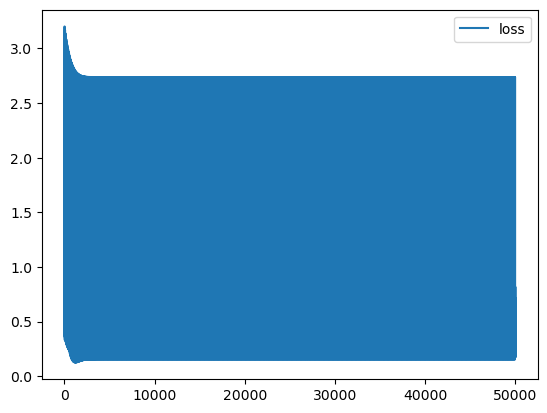

[ Info: Epoch 1: train step: 0, loss: 1.9753516453972413
[ Info: Epoch 11: train step: 500, loss: 1.0200424186394086
[ Info: Epoch 21: train step: 1000, loss: 0.5324381168226927
[ Info: Epoch 31: train step: 1500, loss: 0.33913728427513246
[ Info: Epoch 41: train step: 2000, loss: 0.3051761460966934
[ Info: Epoch 51: train step: 2500, loss: 0.3307705143847294
[ Info: Epoch 61: train step: 3000, loss: 0.3598554195068681
[ Info: Epoch 71: train step: 3500, loss: 0.3756691958483548
[ Info: Epoch 81: train step: 4000, loss: 0.3813832517941113
[ Info: Epoch 91: train step: 4500, loss: 0.3828724804838142
[ Info: Epoch 101: train step: 5000, loss: 0.3831616281817901
[ Info: Epoch 111: train step: 5500, loss: 0.3832016355767469
[ Info: Epoch 121: train step: 6000, loss: 0.38320346847050385
[ Info: Epoch 131: train step: 6500, loss: 0.3832016831877426
[ Info: Epoch 141: train step: 7000, loss: 0.38320034235014766
[ Info: Epoch 151: train step: 7500, loss: 0.3831993998684041
[ Info: Epoch 161: t

[ Info: Epoch 841: train step: 42000, loss: 0.383198400539056
[ Info: Epoch 851: train step: 42500, loss: 0.383198400539056
[ Info: Epoch 861: train step: 43000, loss: 0.383198400539056
[ Info: Epoch 871: train step: 43500, loss: 0.383198400539056
[ Info: Epoch 881: train step: 44000, loss: 0.383198400539056
[ Info: Epoch 891: train step: 44500, loss: 0.383198400539056
[ Info: Epoch 901: train step: 45000, loss: 0.383198400539056
[ Info: Epoch 911: train step: 45500, loss: 0.383198400539056
[ Info: Epoch 921: train step: 46000, loss: 0.383198400539056
[ Info: Epoch 931: train step: 46500, loss: 0.383198400539056
[ Info: Epoch 941: train step: 47000, loss: 0.383198400539056
[ Info: Epoch 951: train step: 47500, loss: 0.383198400539056
[ Info: Epoch 961: train step: 48000, loss: 0.383198400539056
[ Info: Epoch 971: train step: 48500, loss: 0.383198400539056
[ Info: Epoch 981: train step: 49000, loss: 0.383198400539056
[ Info: Epoch 991: train step: 49500, loss: 0.383198400539056


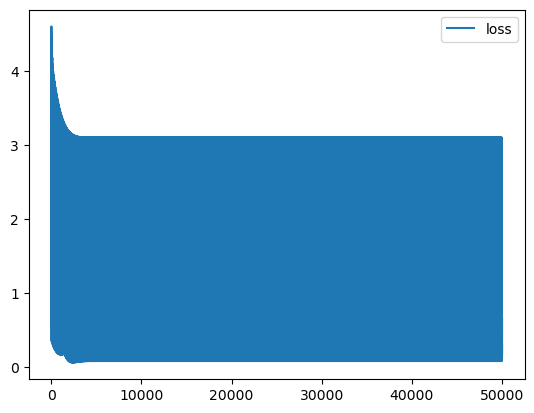

[ Info: Epoch 1: train step: 0, loss: 1.0217755643324657
[ Info: Epoch 11: train step: 500, loss: 0.506119557705388
[ Info: Epoch 21: train step: 1000, loss: 0.3171477226168931
[ Info: Epoch 31: train step: 1500, loss: 0.267292967071043
[ Info: Epoch 41: train step: 2000, loss: 0.257926963193718
[ Info: Epoch 51: train step: 2500, loss: 0.25641440444774316
[ Info: Epoch 61: train step: 3000, loss: 0.2561637981169481
[ Info: Epoch 71: train step: 3500, loss: 0.2561224666863922
[ Info: Epoch 81: train step: 4000, loss: 0.2561137460876633
[ Info: Epoch 91: train step: 4500, loss: 0.2561102518900863
[ Info: Epoch 101: train step: 5000, loss: 0.25610826756513916
[ Info: Epoch 111: train step: 5500, loss: 0.25610703904181353
[ Info: Epoch 121: train step: 6000, loss: 0.25610629123218387
[ Info: Epoch 131: train step: 6500, loss: 0.25610582558710604
[ Info: Epoch 141: train step: 7000, loss: 0.2561055635515251
[ Info: Epoch 151: train step: 7500, loss: 0.2561053816055625
[ Info: Epoch 161: tr

[ Info: Epoch 821: train step: 41000, loss: 0.25610511248366463
[ Info: Epoch 831: train step: 41500, loss: 0.25610511258264773
[ Info: Epoch 841: train step: 42000, loss: 0.25610511248366463
[ Info: Epoch 851: train step: 42500, loss: 0.25610511258264773
[ Info: Epoch 861: train step: 43000, loss: 0.25610511248366463
[ Info: Epoch 871: train step: 43500, loss: 0.25610511258264773
[ Info: Epoch 881: train step: 44000, loss: 0.25610511248366463
[ Info: Epoch 891: train step: 44500, loss: 0.25610511258264773
[ Info: Epoch 901: train step: 45000, loss: 0.25610511248366463
[ Info: Epoch 911: train step: 45500, loss: 0.25610511258264773
[ Info: Epoch 921: train step: 46000, loss: 0.25610511248366463
[ Info: Epoch 931: train step: 46500, loss: 0.25610511258264773
[ Info: Epoch 941: train step: 47000, loss: 0.25610511248366463
[ Info: Epoch 951: train step: 47500, loss: 0.25610511258264773
[ Info: Epoch 961: train step: 48000, loss: 0.25610511248366463
[ Info: Epoch 971: train step: 48500, lo

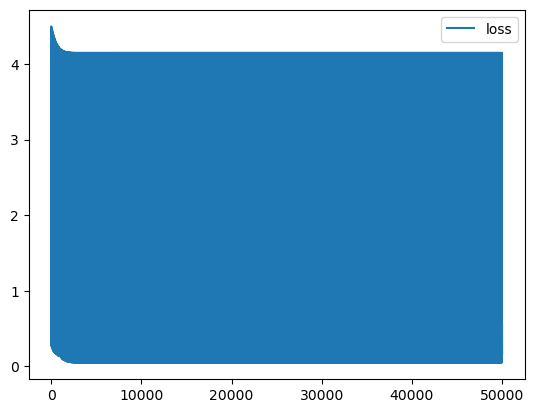

[ Info: Epoch 1: train step: 0, loss: 1.0674108851065143
[ Info: Epoch 11: train step: 500, loss: 0.5094926624003342
[ Info: Epoch 21: train step: 1000, loss: 0.28623261398252725
[ Info: Epoch 31: train step: 1500, loss: 0.2167027196212375
[ Info: Epoch 41: train step: 2000, loss: 0.19932760773923
[ Info: Epoch 51: train step: 2500, loss: 0.1954854319622359
[ Info: Epoch 61: train step: 3000, loss: 0.19475881084866525
[ Info: Epoch 71: train step: 3500, loss: 0.19465820431191463
[ Info: Epoch 81: train step: 4000, loss: 0.19465369746393463
[ Info: Epoch 91: train step: 4500, loss: 0.19465859644678302
[ Info: Epoch 101: train step: 5000, loss: 0.19466269628236385
[ Info: Epoch 111: train step: 5500, loss: 0.1946653801842367
[ Info: Epoch 121: train step: 6000, loss: 0.19466717993794105
[ Info: Epoch 131: train step: 6500, loss: 0.19466828535231778
[ Info: Epoch 141: train step: 7000, loss: 0.19466892791006046
[ Info: Epoch 151: train step: 7500, loss: 0.19466933753345997
[ Info: Epoch 1

[ Info: Epoch 881: train step: 44000, loss: 0.1946699166120031
[ Info: Epoch 891: train step: 44500, loss: 0.1946699166120031
[ Info: Epoch 901: train step: 45000, loss: 0.1946699166120031
[ Info: Epoch 911: train step: 45500, loss: 0.1946699166120031
[ Info: Epoch 921: train step: 46000, loss: 0.1946699166120031
[ Info: Epoch 931: train step: 46500, loss: 0.1946699166120031
[ Info: Epoch 941: train step: 47000, loss: 0.1946699166120031
[ Info: Epoch 951: train step: 47500, loss: 0.1946699166120031
[ Info: Epoch 961: train step: 48000, loss: 0.1946699166120031
[ Info: Epoch 971: train step: 48500, loss: 0.1946699166120031
[ Info: Epoch 981: train step: 49000, loss: 0.1946699166120031
[ Info: Epoch 991: train step: 49500, loss: 0.1946699166120031


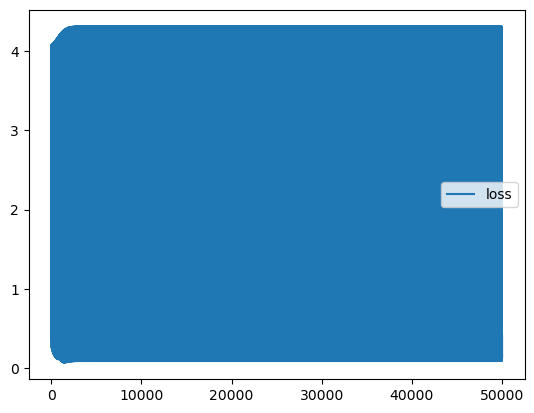

[ Info: Epoch 1: train step: 0, loss: 3.1750435160490227
[ Info: Epoch 11: train step: 500, loss: 1.9476569624727094
[ Info: Epoch 21: train step: 1000, loss: 1.1426211929965802
[ Info: Epoch 31: train step: 1500, loss: 0.646891389752671
[ Info: Epoch 41: train step: 2000, loss: 0.3696369754592502
[ Info: Epoch 51: train step: 2500, loss: 0.23359488937552714
[ Info: Epoch 61: train step: 3000, loss: 0.17692078958659102
[ Info: Epoch 71: train step: 3500, loss: 0.15704212436208417
[ Info: Epoch 81: train step: 4000, loss: 0.1509361681892231
[ Info: Epoch 91: train step: 4500, loss: 0.14922031392569543
[ Info: Epoch 101: train step: 5000, loss: 0.1488012480764675
[ Info: Epoch 111: train step: 5500, loss: 0.14872506637302943
[ Info: Epoch 121: train step: 6000, loss: 0.1487202444799061
[ Info: Epoch 131: train step: 6500, loss: 0.14872524156463168
[ Info: Epoch 141: train step: 7000, loss: 0.14872988154954717
[ Info: Epoch 151: train step: 7500, loss: 0.14873317200874858
[ Info: Epoch 16

[ Info: Epoch 861: train step: 43000, loss: 0.14873872709710073
[ Info: Epoch 871: train step: 43500, loss: 0.14873872709710073
[ Info: Epoch 881: train step: 44000, loss: 0.14873872709710073
[ Info: Epoch 891: train step: 44500, loss: 0.14873872709710073
[ Info: Epoch 901: train step: 45000, loss: 0.14873872709710073
[ Info: Epoch 911: train step: 45500, loss: 0.14873872709710073
[ Info: Epoch 921: train step: 46000, loss: 0.14873872709710073
[ Info: Epoch 931: train step: 46500, loss: 0.14873872709710073
[ Info: Epoch 941: train step: 47000, loss: 0.14873872709710073
[ Info: Epoch 951: train step: 47500, loss: 0.14873872709710073
[ Info: Epoch 961: train step: 48000, loss: 0.14873872709710073
[ Info: Epoch 971: train step: 48500, loss: 0.14873872709710073
[ Info: Epoch 981: train step: 49000, loss: 0.14873872709710073
[ Info: Epoch 991: train step: 49500, loss: 0.14873872709710073


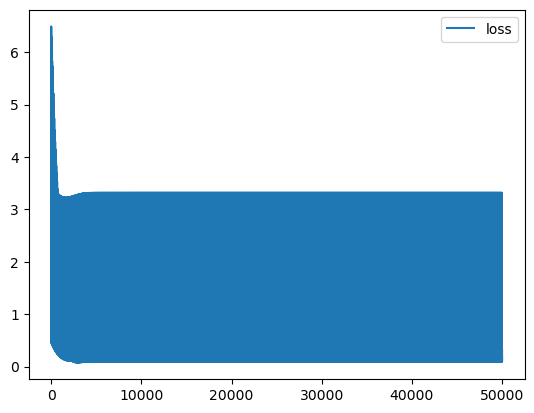

[ Info: Epoch 1: train step: 0, loss: 3.3061832788629615
[ Info: Epoch 11: train step: 500, loss: 2.0722855359965417
[ Info: Epoch 21: train step: 1000, loss: 1.2371091111824073
[ Info: Epoch 31: train step: 1500, loss: 0.6999605110254692
[ Info: Epoch 41: train step: 2000, loss: 0.3830599838020913
[ Info: Epoch 51: train step: 2500, loss: 0.2185313749241145
[ Info: Epoch 61: train step: 3000, loss: 0.14797449048308997
[ Info: Epoch 71: train step: 3500, loss: 0.12548216804923906
[ Info: Epoch 81: train step: 4000, loss: 0.12132813980320019
[ Info: Epoch 91: train step: 4500, loss: 0.12148960992267024
[ Info: Epoch 101: train step: 5000, loss: 0.12186102021746739
[ Info: Epoch 111: train step: 5500, loss: 0.12198555554920376
[ Info: Epoch 121: train step: 6000, loss: 0.12200742438681689
[ Info: Epoch 131: train step: 6500, loss: 0.12200669410691152
[ Info: Epoch 141: train step: 7000, loss: 0.12200350612527319
[ Info: Epoch 151: train step: 7500, loss: 0.1220009577698645
[ Info: Epoch 

[ Info: Epoch 821: train step: 41000, loss: 0.12199633814424442
[ Info: Epoch 831: train step: 41500, loss: 0.12199633814424442
[ Info: Epoch 841: train step: 42000, loss: 0.12199633814424442
[ Info: Epoch 851: train step: 42500, loss: 0.12199633814424442
[ Info: Epoch 861: train step: 43000, loss: 0.12199633814424442
[ Info: Epoch 871: train step: 43500, loss: 0.12199633814424442
[ Info: Epoch 881: train step: 44000, loss: 0.12199633814424442
[ Info: Epoch 891: train step: 44500, loss: 0.12199633814424442
[ Info: Epoch 901: train step: 45000, loss: 0.12199633814424442
[ Info: Epoch 911: train step: 45500, loss: 0.12199633814424442
[ Info: Epoch 921: train step: 46000, loss: 0.12199633814424442
[ Info: Epoch 931: train step: 46500, loss: 0.12199633814424442
[ Info: Epoch 941: train step: 47000, loss: 0.12199633814424442
[ Info: Epoch 951: train step: 47500, loss: 0.12199633814424442
[ Info: Epoch 961: train step: 48000, loss: 0.12199633814424442
[ Info: Epoch 971: train step: 48500, lo

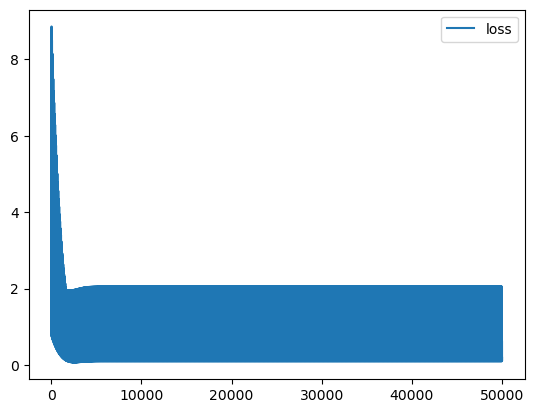

[ Info: Epoch 1: train step: 0, loss: 3.088235929391519
[ Info: Epoch 11: train step: 500, loss: 1.9853823661778986
[ Info: Epoch 21: train step: 1000, loss: 1.219387490513771
[ Info: Epoch 31: train step: 1500, loss: 0.7078258293060944
[ Info: Epoch 41: train step: 2000, loss: 0.39123708571698057
[ Info: Epoch 51: train step: 2500, loss: 0.21716790615012474
[ Info: Epoch 61: train step: 3000, loss: 0.1384849598236198
[ Info: Epoch 71: train step: 3500, loss: 0.11444724766983654
[ Info: Epoch 81: train step: 4000, loss: 0.11405151132758964
[ Info: Epoch 91: train step: 4500, loss: 0.11896744336221299
[ Info: Epoch 101: train step: 5000, loss: 0.12235798960512548
[ Info: Epoch 111: train step: 5500, loss: 0.1237197049916026
[ Info: Epoch 121: train step: 6000, loss: 0.12409309027595299
[ Info: Epoch 131: train step: 6500, loss: 0.124160465901583
[ Info: Epoch 141: train step: 7000, loss: 0.12416219123328087
[ Info: Epoch 151: train step: 7500, loss: 0.1241553296153843
[ Info: Epoch 161:

[ Info: Epoch 821: train step: 41000, loss: 0.12413913433729662
[ Info: Epoch 831: train step: 41500, loss: 0.12413913433729662
[ Info: Epoch 841: train step: 42000, loss: 0.12413913433729662
[ Info: Epoch 851: train step: 42500, loss: 0.12413913433729662
[ Info: Epoch 861: train step: 43000, loss: 0.12413913433729662
[ Info: Epoch 871: train step: 43500, loss: 0.12413913433729662
[ Info: Epoch 881: train step: 44000, loss: 0.12413913433729662
[ Info: Epoch 891: train step: 44500, loss: 0.12413913433729662
[ Info: Epoch 901: train step: 45000, loss: 0.12413913433729662
[ Info: Epoch 911: train step: 45500, loss: 0.12413913433729662
[ Info: Epoch 921: train step: 46000, loss: 0.12413913433729662
[ Info: Epoch 931: train step: 46500, loss: 0.12413913433729662
[ Info: Epoch 941: train step: 47000, loss: 0.12413913433729662
[ Info: Epoch 951: train step: 47500, loss: 0.12413913433729662
[ Info: Epoch 961: train step: 48000, loss: 0.12413913433729662
[ Info: Epoch 971: train step: 48500, lo

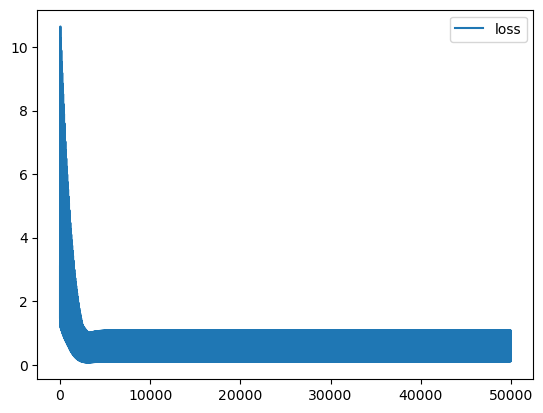

[ Info: Epoch 1: train step: 0, loss: 0.5313759482031765
[ Info: Epoch 11: train step: 500, loss: 0.24719611177278794
[ Info: Epoch 21: train step: 1000, loss: 0.16866126771363332
[ Info: Epoch 31: train step: 1500, loss: 0.15179702475211798
[ Info: Epoch 41: train step: 2000, loss: 0.14860540848889786
[ Info: Epoch 51: train step: 2500, loss: 0.14808335324623711
[ Info: Epoch 61: train step: 3000, loss: 0.14800875926238305
[ Info: Epoch 71: train step: 3500, loss: 0.14799690116410233
[ Info: Epoch 81: train step: 4000, loss: 0.14799353957346262
[ Info: Epoch 91: train step: 4500, loss: 0.14799176796404231
[ Info: Epoch 101: train step: 5000, loss: 0.14799073753008707
[ Info: Epoch 111: train step: 5500, loss: 0.1479900969736747
[ Info: Epoch 121: train step: 6000, loss: 0.14798974563329126
[ Info: Epoch 131: train step: 6500, loss: 0.1479895177963023
[ Info: Epoch 141: train step: 7000, loss: 0.14798935919963463
[ Info: Epoch 151: train step: 7500, loss: 0.147989374436765
[ Info: Epoc

[ Info: Epoch 841: train step: 42000, loss: 0.14798894076438712
[ Info: Epoch 851: train step: 42500, loss: 0.14798894053132156
[ Info: Epoch 861: train step: 43000, loss: 0.14798894072758725
[ Info: Epoch 871: train step: 43500, loss: 0.147988940923853
[ Info: Epoch 881: train step: 44000, loss: 0.14798894056812134
[ Info: Epoch 891: train step: 44500, loss: 0.1479889406294544
[ Info: Epoch 901: train step: 45000, loss: 0.14798894082572014
[ Info: Epoch 911: train step: 45500, loss: 0.14798894076438712
[ Info: Epoch 921: train step: 46000, loss: 0.14798894053132156
[ Info: Epoch 931: train step: 46500, loss: 0.14798894072758725
[ Info: Epoch 941: train step: 47000, loss: 0.147988940923853
[ Info: Epoch 951: train step: 47500, loss: 0.14798894056812134
[ Info: Epoch 961: train step: 48000, loss: 0.1479889406294544
[ Info: Epoch 971: train step: 48500, loss: 0.14798894082572014
[ Info: Epoch 981: train step: 49000, loss: 0.14798894076438712
[ Info: Epoch 991: train step: 49500, loss: 0.

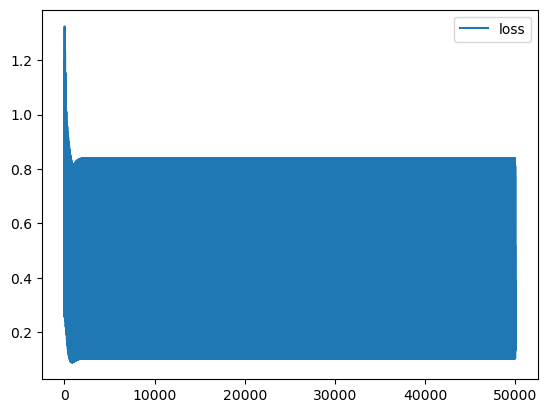

[ Info: Epoch 1: train step: 0, loss: 3.2546289327170896
[ Info: Epoch 11: train step: 500, loss: 2.06387676952886
[ Info: Epoch 21: train step: 1000, loss: 1.254126599928959
[ Info: Epoch 31: train step: 1500, loss: 0.7338698208242646
[ Info: Epoch 41: train step: 2000, loss: 0.4295684010745716
[ Info: Epoch 51: train step: 2500, loss: 0.2762396889957054
[ Info: Epoch 61: train step: 3000, loss: 0.21673921380311706
[ Info: Epoch 71: train step: 3500, loss: 0.20457272626213746
[ Info: Epoch 81: train step: 4000, loss: 0.20839279611489822
[ Info: Epoch 91: train step: 4500, loss: 0.2132553902348306
[ Info: Epoch 101: train step: 5000, loss: 0.21566977120522654
[ Info: Epoch 111: train step: 5500, loss: 0.21644570594840123
[ Info: Epoch 121: train step: 6000, loss: 0.2166211595373154
[ Info: Epoch 131: train step: 6500, loss: 0.2166465660898666
[ Info: Epoch 141: train step: 7000, loss: 0.21664562832244244
[ Info: Epoch 151: train step: 7500, loss: 0.21664216718595714
[ Info: Epoch 161: 

[ Info: Epoch 841: train step: 42000, loss: 0.2166350193042894
[ Info: Epoch 851: train step: 42500, loss: 0.2166350193042894
[ Info: Epoch 861: train step: 43000, loss: 0.2166350193042894
[ Info: Epoch 871: train step: 43500, loss: 0.2166350193042894
[ Info: Epoch 881: train step: 44000, loss: 0.2166350193042894
[ Info: Epoch 891: train step: 44500, loss: 0.2166350193042894
[ Info: Epoch 901: train step: 45000, loss: 0.2166350193042894
[ Info: Epoch 911: train step: 45500, loss: 0.2166350193042894
[ Info: Epoch 921: train step: 46000, loss: 0.2166350193042894
[ Info: Epoch 931: train step: 46500, loss: 0.2166350193042894
[ Info: Epoch 941: train step: 47000, loss: 0.2166350193042894
[ Info: Epoch 951: train step: 47500, loss: 0.2166350193042894
[ Info: Epoch 961: train step: 48000, loss: 0.2166350193042894
[ Info: Epoch 971: train step: 48500, loss: 0.2166350193042894
[ Info: Epoch 981: train step: 49000, loss: 0.2166350193042894
[ Info: Epoch 991: train step: 49500, loss: 0.216635019

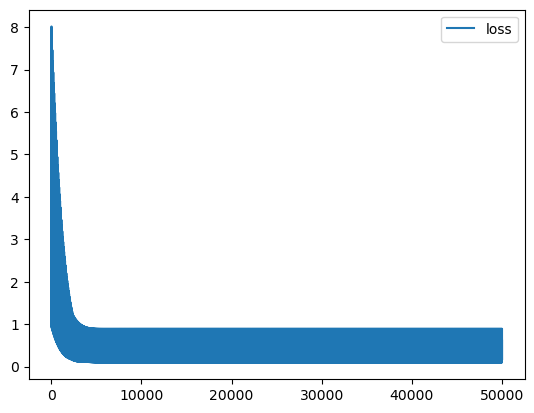

[ Info: Epoch 1: train step: 0, loss: 0.39090105999820873
[ Info: Epoch 11: train step: 500, loss: 0.29152728570385145
[ Info: Epoch 21: train step: 1000, loss: 0.29109083956577475
[ Info: Epoch 31: train step: 1500, loss: 0.2926952106994918
[ Info: Epoch 41: train step: 2000, loss: 0.29292806540981803
[ Info: Epoch 51: train step: 2500, loss: 0.29295016548557895
[ Info: Epoch 61: train step: 3000, loss: 0.29295110316979506
[ Info: Epoch 71: train step: 3500, loss: 0.292950553501137
[ Info: Epoch 81: train step: 4000, loss: 0.2929501570925842
[ Info: Epoch 91: train step: 4500, loss: 0.29294989368225277
[ Info: Epoch 101: train step: 5000, loss: 0.2929497297586833
[ Info: Epoch 111: train step: 5500, loss: 0.29294964164119675
[ Info: Epoch 121: train step: 6000, loss: 0.29294961638742084
[ Info: Epoch 131: train step: 6500, loss: 0.2929495613241563
[ Info: Epoch 141: train step: 7000, loss: 0.29294952582248174
[ Info: Epoch 151: train step: 7500, loss: 0.29294956099371067
[ Info: Epoch

[ Info: Epoch 861: train step: 43000, loss: 0.29294955674531514
[ Info: Epoch 871: train step: 43500, loss: 0.29294955674531514
[ Info: Epoch 881: train step: 44000, loss: 0.29294955674531514
[ Info: Epoch 891: train step: 44500, loss: 0.29294955674531514
[ Info: Epoch 901: train step: 45000, loss: 0.29294955674531514
[ Info: Epoch 911: train step: 45500, loss: 0.29294955674531514
[ Info: Epoch 921: train step: 46000, loss: 0.29294955674531514
[ Info: Epoch 931: train step: 46500, loss: 0.29294955674531514
[ Info: Epoch 941: train step: 47000, loss: 0.29294955674531514
[ Info: Epoch 951: train step: 47500, loss: 0.29294955674531514
[ Info: Epoch 961: train step: 48000, loss: 0.29294955674531514
[ Info: Epoch 971: train step: 48500, loss: 0.29294955674531514
[ Info: Epoch 981: train step: 49000, loss: 0.29294955674531514
[ Info: Epoch 991: train step: 49500, loss: 0.29294955674531514


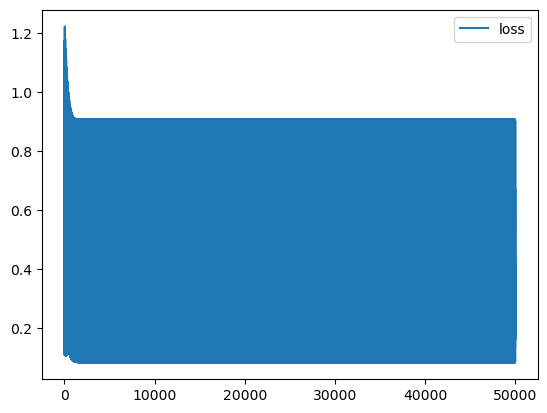

[ Info: Epoch 1: train step: 0, loss: 2.397926448373055
[ Info: Epoch 11: train step: 500, loss: 1.5052221705655082
[ Info: Epoch 21: train step: 1000, loss: 0.9388075205971509
[ Info: Epoch 31: train step: 1500, loss: 0.6098770806311711
[ Info: Epoch 41: train step: 2000, loss: 0.4417599022181177
[ Info: Epoch 51: train step: 2500, loss: 0.37040146653784944
[ Info: Epoch 61: train step: 3000, loss: 0.34710227418555667
[ Info: Epoch 71: train step: 3500, loss: 0.34176474644833443
[ Info: Epoch 81: train step: 4000, loss: 0.3409944539582819
[ Info: Epoch 91: train step: 4500, loss: 0.34093620961994964
[ Info: Epoch 101: train step: 5000, loss: 0.34093566016136645
[ Info: Epoch 111: train step: 5500, loss: 0.340935585341342
[ Info: Epoch 121: train step: 6000, loss: 0.3409351764955589
[ Info: Epoch 131: train step: 6500, loss: 0.34093484860446344
[ Info: Epoch 141: train step: 7000, loss: 0.34093463156570153
[ Info: Epoch 151: train step: 7500, loss: 0.34093449356647865
[ Info: Epoch 161

[ Info: Epoch 861: train step: 43000, loss: 0.3409342726532487
[ Info: Epoch 871: train step: 43500, loss: 0.3409342726532487
[ Info: Epoch 881: train step: 44000, loss: 0.3409342726532487
[ Info: Epoch 891: train step: 44500, loss: 0.3409342726532487
[ Info: Epoch 901: train step: 45000, loss: 0.3409342726532487
[ Info: Epoch 911: train step: 45500, loss: 0.3409342726532487
[ Info: Epoch 921: train step: 46000, loss: 0.3409342726532487
[ Info: Epoch 931: train step: 46500, loss: 0.3409342726532487
[ Info: Epoch 941: train step: 47000, loss: 0.3409342726532487
[ Info: Epoch 951: train step: 47500, loss: 0.3409342726532487
[ Info: Epoch 961: train step: 48000, loss: 0.3409342726532487
[ Info: Epoch 971: train step: 48500, loss: 0.3409342726532487
[ Info: Epoch 981: train step: 49000, loss: 0.3409342726532487
[ Info: Epoch 991: train step: 49500, loss: 0.3409342726532487


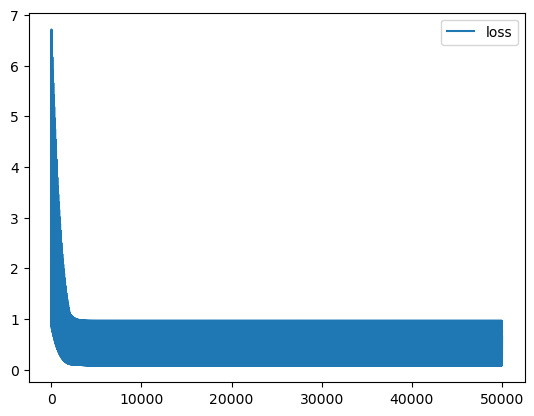

[ Info: Epoch 1: train step: 0, loss: 0.5637703649670198
[ Info: Epoch 11: train step: 500, loss: 0.4073491358744624
[ Info: Epoch 21: train step: 1000, loss: 0.382261698393705
[ Info: Epoch 31: train step: 1500, loss: 0.37924067196321526
[ Info: Epoch 41: train step: 2000, loss: 0.378911111593961
[ Info: Epoch 51: train step: 2500, loss: 0.37888330731815134
[ Info: Epoch 61: train step: 3000, loss: 0.3788827776312592
[ Info: Epoch 71: train step: 3500, loss: 0.37888375040580563
[ Info: Epoch 81: train step: 4000, loss: 0.37888441986436794
[ Info: Epoch 91: train step: 4500, loss: 0.3788848548450073
[ Info: Epoch 101: train step: 5000, loss: 0.3788851014222046
[ Info: Epoch 111: train step: 5500, loss: 0.3788852886323128
[ Info: Epoch 121: train step: 6000, loss: 0.378885323901825
[ Info: Epoch 131: train step: 6500, loss: 0.3788853867036309
[ Info: Epoch 141: train step: 7000, loss: 0.3788854378324927
[ Info: Epoch 151: train step: 7500, loss: 0.37888542863273383
[ Info: Epoch 161: tr

[ Info: Epoch 821: train step: 41000, loss: 0.3788855246115789
[ Info: Epoch 831: train step: 41500, loss: 0.3788855246115789
[ Info: Epoch 841: train step: 42000, loss: 0.3788855246115789
[ Info: Epoch 851: train step: 42500, loss: 0.3788855246115789
[ Info: Epoch 861: train step: 43000, loss: 0.3788855246115789
[ Info: Epoch 871: train step: 43500, loss: 0.3788855246115789
[ Info: Epoch 881: train step: 44000, loss: 0.3788855246115789
[ Info: Epoch 891: train step: 44500, loss: 0.3788855246115789
[ Info: Epoch 901: train step: 45000, loss: 0.3788855246115789
[ Info: Epoch 911: train step: 45500, loss: 0.3788855246115789
[ Info: Epoch 921: train step: 46000, loss: 0.3788855246115789
[ Info: Epoch 931: train step: 46500, loss: 0.3788855246115789
[ Info: Epoch 941: train step: 47000, loss: 0.3788855246115789
[ Info: Epoch 951: train step: 47500, loss: 0.3788855246115789
[ Info: Epoch 961: train step: 48000, loss: 0.3788855246115789
[ Info: Epoch 971: train step: 48500, loss: 0.378885524

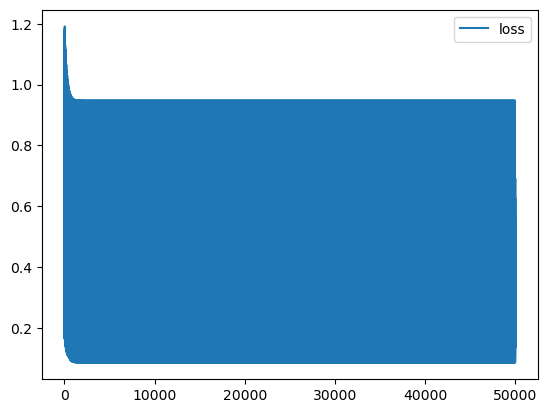

[ Info: Epoch 1: train step: 0, loss: 1.528762700230533
[ Info: Epoch 11: train step: 500, loss: 0.9981446835850921
[ Info: Epoch 21: train step: 1000, loss: 0.6890252256540034
[ Info: Epoch 31: train step: 1500, loss: 0.5288754370243982
[ Info: Epoch 41: train step: 2000, loss: 0.4575799507477566
[ Info: Epoch 51: train step: 2500, loss: 0.43090818033317246
[ Info: Epoch 61: train step: 3000, loss: 0.4223457678101831
[ Info: Epoch 71: train step: 3500, loss: 0.41989528940926474
[ Info: Epoch 81: train step: 4000, loss: 0.41929798868711626
[ Info: Epoch 91: train step: 4500, loss: 0.4191926313125851
[ Info: Epoch 101: train step: 5000, loss: 0.41918700829754396
[ Info: Epoch 111: train step: 5500, loss: 0.41919385446814356
[ Info: Epoch 121: train step: 6000, loss: 0.4191998281213255
[ Info: Epoch 131: train step: 6500, loss: 0.4192038863401352
[ Info: Epoch 141: train step: 7000, loss: 0.4192065423462895
[ Info: Epoch 151: train step: 7500, loss: 0.419208203775276
[ Info: Epoch 161: t

[ Info: Epoch 861: train step: 43000, loss: 0.419210940171618
[ Info: Epoch 871: train step: 43500, loss: 0.419210940171618
[ Info: Epoch 881: train step: 44000, loss: 0.419210940171618
[ Info: Epoch 891: train step: 44500, loss: 0.419210940171618
[ Info: Epoch 901: train step: 45000, loss: 0.419210940171618
[ Info: Epoch 911: train step: 45500, loss: 0.419210940171618
[ Info: Epoch 921: train step: 46000, loss: 0.419210940171618
[ Info: Epoch 931: train step: 46500, loss: 0.419210940171618
[ Info: Epoch 941: train step: 47000, loss: 0.419210940171618
[ Info: Epoch 951: train step: 47500, loss: 0.419210940171618
[ Info: Epoch 961: train step: 48000, loss: 0.419210940171618
[ Info: Epoch 971: train step: 48500, loss: 0.419210940171618
[ Info: Epoch 981: train step: 49000, loss: 0.419210940171618
[ Info: Epoch 991: train step: 49500, loss: 0.419210940171618


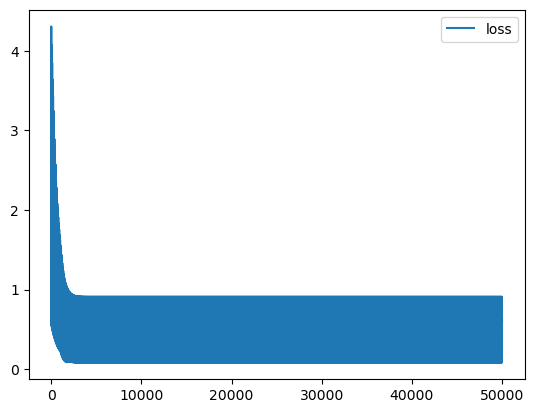

[ Info: Epoch 1: train step: 0, loss: 2.3614643372961264
[ Info: Epoch 11: train step: 500, loss: 1.7082240788816023
[ Info: Epoch 21: train step: 1000, loss: 1.2354004878620688
[ Info: Epoch 31: train step: 1500, loss: 0.9076212719259125
[ Info: Epoch 41: train step: 2000, loss: 0.6924214065682344
[ Info: Epoch 51: train step: 2500, loss: 0.5614475724361334
[ Info: Epoch 61: train step: 3000, loss: 0.4894463557284194
[ Info: Epoch 71: train step: 3500, loss: 0.4546029991322678
[ Info: Epoch 81: train step: 4000, loss: 0.43995060163334887
[ Info: Epoch 91: train step: 4500, loss: 0.43452667812354767
[ Info: Epoch 101: train step: 5000, loss: 0.4327319394804875
[ Info: Epoch 111: train step: 5500, loss: 0.43222635849973196
[ Info: Epoch 121: train step: 6000, loss: 0.4321222640057896
[ Info: Epoch 131: train step: 6500, loss: 0.4321148436400682
[ Info: Epoch 141: train step: 7000, loss: 0.43212212929305915
[ Info: Epoch 151: train step: 7500, loss: 0.4321288297639622
[ Info: Epoch 161: 

[ Info: Epoch 841: train step: 42000, loss: 0.43214180244233935
[ Info: Epoch 851: train step: 42500, loss: 0.43214180244233935
[ Info: Epoch 861: train step: 43000, loss: 0.43214180244233935
[ Info: Epoch 871: train step: 43500, loss: 0.43214180244233935
[ Info: Epoch 881: train step: 44000, loss: 0.43214180244233935
[ Info: Epoch 891: train step: 44500, loss: 0.43214180244233935
[ Info: Epoch 901: train step: 45000, loss: 0.43214180244233935
[ Info: Epoch 911: train step: 45500, loss: 0.43214180244233935
[ Info: Epoch 921: train step: 46000, loss: 0.43214180244233935
[ Info: Epoch 931: train step: 46500, loss: 0.43214180244233935
[ Info: Epoch 941: train step: 47000, loss: 0.43214180244233935
[ Info: Epoch 951: train step: 47500, loss: 0.43214180244233935
[ Info: Epoch 961: train step: 48000, loss: 0.43214180244233935
[ Info: Epoch 971: train step: 48500, loss: 0.43214180244233935
[ Info: Epoch 981: train step: 49000, loss: 0.43214180244233935
[ Info: Epoch 991: train step: 49500, lo

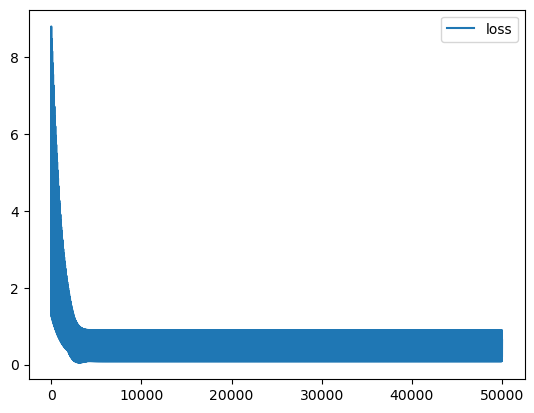

[ Info: Epoch 1: train step: 0, loss: 2.0806421392070957
[ Info: Epoch 11: train step: 500, loss: 1.4445970385595976
[ Info: Epoch 21: train step: 1000, loss: 1.0139136081903974
[ Info: Epoch 31: train step: 1500, loss: 0.7408785816002144
[ Info: Epoch 41: train step: 2000, loss: 0.5832899801263687
[ Info: Epoch 51: train step: 2500, loss: 0.5044183814333082
[ Info: Epoch 61: train step: 3000, loss: 0.47286480060750097
[ Info: Epoch 71: train step: 3500, loss: 0.4643537400252316
[ Info: Epoch 81: train step: 4000, loss: 0.4637306106311902
[ Info: Epoch 91: train step: 4500, loss: 0.46438081843599244
[ Info: Epoch 101: train step: 5000, loss: 0.46473692962514035
[ Info: Epoch 111: train step: 5500, loss: 0.46484355530709476
[ Info: Epoch 121: train step: 6000, loss: 0.4648693315940621
[ Info: Epoch 131: train step: 6500, loss: 0.46487732661204717
[ Info: Epoch 141: train step: 7000, loss: 0.4648814438813956
[ Info: Epoch 151: train step: 7500, loss: 0.4648840365955267
[ Info: Epoch 161:

[ Info: Epoch 821: train step: 41000, loss: 0.46488849734562326
[ Info: Epoch 831: train step: 41500, loss: 0.46488849734562326
[ Info: Epoch 841: train step: 42000, loss: 0.46488849734562326
[ Info: Epoch 851: train step: 42500, loss: 0.46488849734562326
[ Info: Epoch 861: train step: 43000, loss: 0.46488849734562326
[ Info: Epoch 871: train step: 43500, loss: 0.46488849734562326
[ Info: Epoch 881: train step: 44000, loss: 0.46488849734562326
[ Info: Epoch 891: train step: 44500, loss: 0.46488849734562326
[ Info: Epoch 901: train step: 45000, loss: 0.46488849734562326
[ Info: Epoch 911: train step: 45500, loss: 0.46488849734562326
[ Info: Epoch 921: train step: 46000, loss: 0.46488849734562326
[ Info: Epoch 931: train step: 46500, loss: 0.46488849734562326
[ Info: Epoch 941: train step: 47000, loss: 0.46488849734562326
[ Info: Epoch 951: train step: 47500, loss: 0.46488849734562326
[ Info: Epoch 961: train step: 48000, loss: 0.46488849734562326
[ Info: Epoch 971: train step: 48500, lo

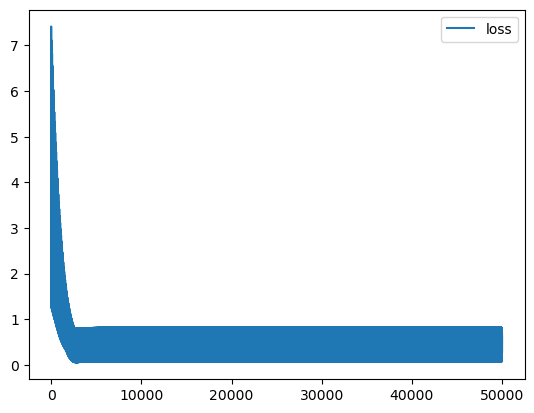

[ Info: Epoch 1: train step: 0, loss: 2.9096769942079397
[ Info: Epoch 11: train step: 500, loss: 1.9849509586709722
[ Info: Epoch 21: train step: 1000, loss: 1.3501747324366091
[ Info: Epoch 31: train step: 1500, loss: 0.9380390602518128
[ Info: Epoch 41: train step: 2000, loss: 0.6924756911107839
[ Info: Epoch 51: train step: 2500, loss: 0.5643261862386519
[ Info: Epoch 61: train step: 3000, loss: 0.5104691874306406
[ Info: Epoch 71: train step: 3500, loss: 0.4956221362521786
[ Info: Epoch 81: train step: 4000, loss: 0.49549059309674526
[ Info: Epoch 91: train step: 4500, loss: 0.497840547583141
[ Info: Epoch 101: train step: 5000, loss: 0.49918433290894093
[ Info: Epoch 111: train step: 5500, loss: 0.49962707404158363
[ Info: Epoch 121: train step: 6000, loss: 0.49972834775543157
[ Info: Epoch 131: train step: 6500, loss: 0.49974685663756
[ Info: Epoch 141: train step: 7000, loss: 0.49975084461062186
[ Info: Epoch 151: train step: 7500, loss: 0.49975253662164754
[ Info: Epoch 161: t

[ Info: Epoch 821: train step: 41000, loss: 0.4997553165520204
[ Info: Epoch 831: train step: 41500, loss: 0.4997553165520204
[ Info: Epoch 841: train step: 42000, loss: 0.4997553165520204
[ Info: Epoch 851: train step: 42500, loss: 0.4997553165520204
[ Info: Epoch 861: train step: 43000, loss: 0.4997553165520204
[ Info: Epoch 871: train step: 43500, loss: 0.4997553165520204
[ Info: Epoch 881: train step: 44000, loss: 0.4997553165520204
[ Info: Epoch 891: train step: 44500, loss: 0.4997553165520204
[ Info: Epoch 901: train step: 45000, loss: 0.4997553165520204
[ Info: Epoch 911: train step: 45500, loss: 0.4997553165520204
[ Info: Epoch 921: train step: 46000, loss: 0.4997553165520204
[ Info: Epoch 931: train step: 46500, loss: 0.4997553165520204
[ Info: Epoch 941: train step: 47000, loss: 0.4997553165520204
[ Info: Epoch 951: train step: 47500, loss: 0.4997553165520204
[ Info: Epoch 961: train step: 48000, loss: 0.4997553165520204
[ Info: Epoch 971: train step: 48500, loss: 0.499755316

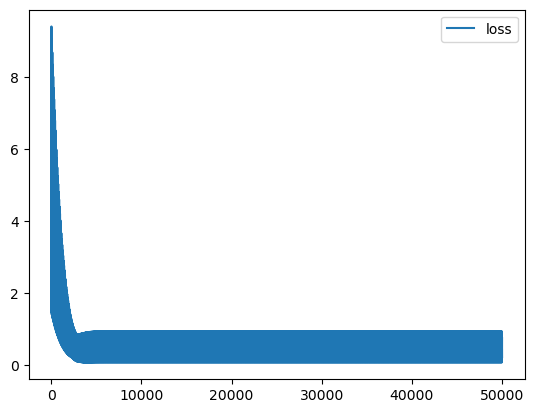

[ Info: Epoch 1: train step: 0, loss: 1.2760375547910061
[ Info: Epoch 11: train step: 500, loss: 0.8629074662654613
[ Info: Epoch 21: train step: 1000, loss: 0.6951284521969915
[ Info: Epoch 31: train step: 1500, loss: 0.6551301517128918
[ Info: Epoch 41: train step: 2000, loss: 0.6606590533532108
[ Info: Epoch 51: train step: 2500, loss: 0.6706811821464617
[ Info: Epoch 61: train step: 3000, loss: 0.6753948596987635
[ Info: Epoch 71: train step: 3500, loss: 0.6767296434316122
[ Info: Epoch 81: train step: 4000, loss: 0.6769900119767589
[ Info: Epoch 91: train step: 4500, loss: 0.6770267134352828
[ Info: Epoch 101: train step: 5000, loss: 0.6770303340389499
[ Info: Epoch 111: train step: 5500, loss: 0.6770302895234434
[ Info: Epoch 121: train step: 6000, loss: 0.6770300075516829
[ Info: Epoch 131: train step: 6500, loss: 0.6770297938555445
[ Info: Epoch 141: train step: 7000, loss: 0.6770296967164963
[ Info: Epoch 151: train step: 7500, loss: 0.6770295916061688
[ Info: Epoch 161: trai

[ Info: Epoch 821: train step: 41000, loss: 0.6770295410517042
[ Info: Epoch 831: train step: 41500, loss: 0.6770295410517042
[ Info: Epoch 841: train step: 42000, loss: 0.6770295410517042
[ Info: Epoch 851: train step: 42500, loss: 0.6770295410517042
[ Info: Epoch 861: train step: 43000, loss: 0.6770295410517042
[ Info: Epoch 871: train step: 43500, loss: 0.6770295410517042
[ Info: Epoch 881: train step: 44000, loss: 0.6770295410517042
[ Info: Epoch 891: train step: 44500, loss: 0.6770295410517042
[ Info: Epoch 901: train step: 45000, loss: 0.6770295410517042
[ Info: Epoch 911: train step: 45500, loss: 0.6770295410517042
[ Info: Epoch 921: train step: 46000, loss: 0.6770295410517042
[ Info: Epoch 931: train step: 46500, loss: 0.6770295410517042
[ Info: Epoch 941: train step: 47000, loss: 0.6770295410517042
[ Info: Epoch 951: train step: 47500, loss: 0.6770295410517042
[ Info: Epoch 961: train step: 48000, loss: 0.6770295410517042
[ Info: Epoch 971: train step: 48500, loss: 0.677029541

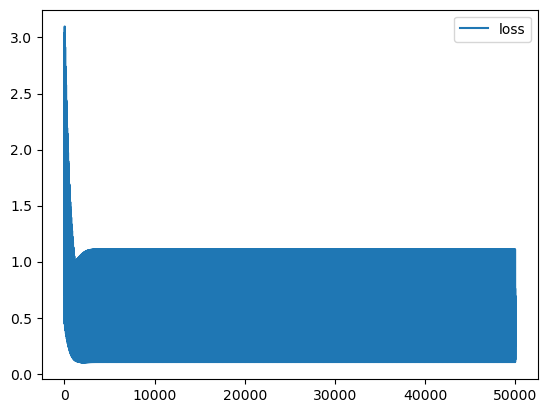

[ Info: Epoch 1: train step: 0, loss: 2.7708356880287113
[ Info: Epoch 11: train step: 500, loss: 2.036221176454162
[ Info: Epoch 21: train step: 1000, loss: 1.5401092297776642
[ Info: Epoch 31: train step: 1500, loss: 1.2256172684916604
[ Info: Epoch 41: train step: 2000, loss: 1.0454933990596993
[ Info: Epoch 51: train step: 2500, loss: 0.9583236790320584
[ Info: Epoch 61: train step: 3000, loss: 0.9279687600212088
[ Info: Epoch 71: train step: 3500, loss: 0.925281919055992
[ Info: Epoch 81: train step: 4000, loss: 0.9308309898627399
[ Info: Epoch 91: train step: 4500, loss: 0.9356068689192654
[ Info: Epoch 101: train step: 5000, loss: 0.937887373847054
[ Info: Epoch 111: train step: 5500, loss: 0.9386391810892623
[ Info: Epoch 121: train step: 6000, loss: 0.938819935252136
[ Info: Epoch 131: train step: 6500, loss: 0.9388505333955044
[ Info: Epoch 141: train step: 7000, loss: 0.9388521639152703
[ Info: Epoch 151: train step: 7500, loss: 0.938850036696018
[ Info: Epoch 161: train ste

[ Info: Epoch 841: train step: 42000, loss: 0.9388448867172497
[ Info: Epoch 851: train step: 42500, loss: 0.9388448866922385
[ Info: Epoch 861: train step: 43000, loss: 0.9388448866672274
[ Info: Epoch 871: train step: 43500, loss: 0.9388448866422161
[ Info: Epoch 881: train step: 44000, loss: 0.9388448867172497
[ Info: Epoch 891: train step: 44500, loss: 0.9388448866922385
[ Info: Epoch 901: train step: 45000, loss: 0.9388448866672274
[ Info: Epoch 911: train step: 45500, loss: 0.9388448866422161
[ Info: Epoch 921: train step: 46000, loss: 0.9388448867172497
[ Info: Epoch 931: train step: 46500, loss: 0.9388448866922385
[ Info: Epoch 941: train step: 47000, loss: 0.9388448866672274
[ Info: Epoch 951: train step: 47500, loss: 0.9388448866422161
[ Info: Epoch 961: train step: 48000, loss: 0.9388448867172497
[ Info: Epoch 971: train step: 48500, loss: 0.9388448866922385
[ Info: Epoch 981: train step: 49000, loss: 0.9388448866672274
[ Info: Epoch 991: train step: 49500, loss: 0.938844886

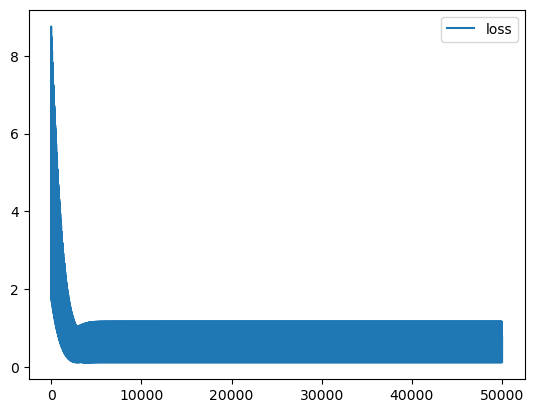

[ Info: Epoch 1: train step: 0, loss: 1.264072902358536
[ Info: Epoch 11: train step: 500, loss: 1.195377475781667
[ Info: Epoch 21: train step: 1000, loss: 1.1863058818166226
[ Info: Epoch 31: train step: 1500, loss: 1.1851242082194244
[ Info: Epoch 41: train step: 2000, loss: 1.1849703543194925
[ Info: Epoch 51: train step: 2500, loss: 1.1849506552155327
[ Info: Epoch 61: train step: 3000, loss: 1.184947670002919
[ Info: Epoch 71: train step: 3500, loss: 1.1849469997897848
[ Info: Epoch 81: train step: 4000, loss: 1.1849466526465304
[ Info: Epoch 91: train step: 4500, loss: 1.1849464775430778
[ Info: Epoch 101: train step: 5000, loss: 1.1849463208220108
[ Info: Epoch 111: train step: 5500, loss: 1.1849462359522247
[ Info: Epoch 121: train step: 6000, loss: 1.1849462089521776
[ Info: Epoch 131: train step: 6500, loss: 1.1849461909200716
[ Info: Epoch 141: train step: 7000, loss: 1.1849461625581446
[ Info: Epoch 151: train step: 7500, loss: 1.1849461549477212
[ Info: Epoch 161: train s

[ Info: Epoch 841: train step: 42000, loss: 1.1849461958409049
[ Info: Epoch 851: train step: 42500, loss: 1.1849461957975065
[ Info: Epoch 861: train step: 43000, loss: 1.184946195884303
[ Info: Epoch 871: train step: 43500, loss: 1.1849461958409049
[ Info: Epoch 881: train step: 44000, loss: 1.1849461957975065
[ Info: Epoch 891: train step: 44500, loss: 1.184946195884303
[ Info: Epoch 901: train step: 45000, loss: 1.1849461958409049
[ Info: Epoch 911: train step: 45500, loss: 1.1849461957975065
[ Info: Epoch 921: train step: 46000, loss: 1.184946195884303
[ Info: Epoch 931: train step: 46500, loss: 1.1849461958409049
[ Info: Epoch 941: train step: 47000, loss: 1.1849461957975065
[ Info: Epoch 951: train step: 47500, loss: 1.184946195884303
[ Info: Epoch 961: train step: 48000, loss: 1.1849461958409049
[ Info: Epoch 971: train step: 48500, loss: 1.1849461957975065
[ Info: Epoch 981: train step: 49000, loss: 1.184946195884303
[ Info: Epoch 991: train step: 49500, loss: 1.18494619584090

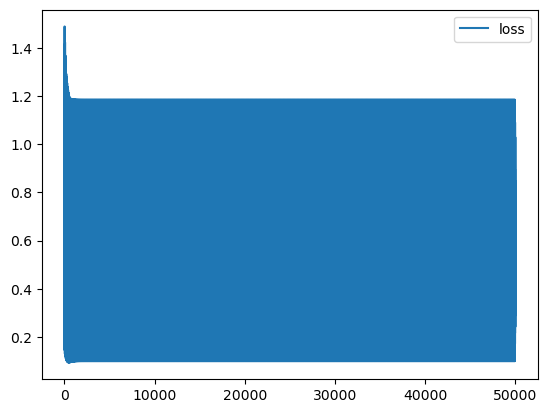

[ Info: Epoch 1: train step: 0, loss: 1.5037152192861059
[ Info: Epoch 11: train step: 500, loss: 1.3806316783387307
[ Info: Epoch 21: train step: 1000, loss: 1.3618201308894229
[ Info: Epoch 31: train step: 1500, loss: 1.3820084733815148
[ Info: Epoch 41: train step: 2000, loss: 1.4031710074868322
[ Info: Epoch 51: train step: 2500, loss: 1.4142106747916174
[ Info: Epoch 61: train step: 3000, loss: 1.4180536073224963
[ Info: Epoch 71: train step: 3500, loss: 1.4190314693062418
[ Info: Epoch 81: train step: 4000, loss: 1.4192148091707237
[ Info: Epoch 91: train step: 4500, loss: 1.4192319480604194
[ Info: Epoch 101: train step: 5000, loss: 1.4192242013213632
[ Info: Epoch 111: train step: 5500, loss: 1.4192162609326153
[ Info: Epoch 121: train step: 6000, loss: 1.4192108834080073
[ Info: Epoch 131: train step: 6500, loss: 1.4192074886505233
[ Info: Epoch 141: train step: 7000, loss: 1.4192053079895155
[ Info: Epoch 151: train step: 7500, loss: 1.4192040105835406
[ Info: Epoch 161: trai

[ Info: Epoch 841: train step: 42000, loss: 1.4192018794649628
[ Info: Epoch 851: train step: 42500, loss: 1.4192018794649628
[ Info: Epoch 861: train step: 43000, loss: 1.4192018794649628
[ Info: Epoch 871: train step: 43500, loss: 1.4192018794649628
[ Info: Epoch 881: train step: 44000, loss: 1.4192018794649628
[ Info: Epoch 891: train step: 44500, loss: 1.4192018794649628
[ Info: Epoch 901: train step: 45000, loss: 1.4192018794649628
[ Info: Epoch 911: train step: 45500, loss: 1.4192018794649628
[ Info: Epoch 921: train step: 46000, loss: 1.4192018794649628
[ Info: Epoch 931: train step: 46500, loss: 1.4192018794649628
[ Info: Epoch 941: train step: 47000, loss: 1.4192018794649628
[ Info: Epoch 951: train step: 47500, loss: 1.4192018794649628
[ Info: Epoch 961: train step: 48000, loss: 1.4192018794649628
[ Info: Epoch 971: train step: 48500, loss: 1.4192018794649628
[ Info: Epoch 981: train step: 49000, loss: 1.4192018794649628
[ Info: Epoch 991: train step: 49500, loss: 1.419201879

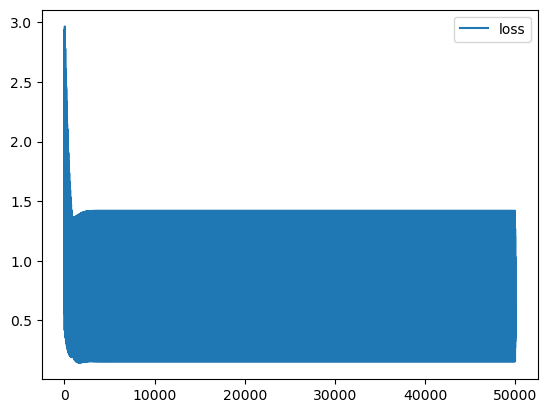

[ Info: Epoch 1: train step: 0, loss: 1.764126436333509
[ Info: Epoch 11: train step: 500, loss: 1.5632250005172132
[ Info: Epoch 21: train step: 1000, loss: 1.4897185706046918
[ Info: Epoch 31: train step: 1500, loss: 1.466824469020846
[ Info: Epoch 41: train step: 2000, loss: 1.4604917646043725
[ Info: Epoch 51: train step: 2500, loss: 1.4589039698141635
[ Info: Epoch 61: train step: 3000, loss: 1.4585474162003371
[ Info: Epoch 71: train step: 3500, loss: 1.458472822818945
[ Info: Epoch 81: train step: 4000, loss: 1.4584561926689867
[ Info: Epoch 91: train step: 4500, loss: 1.4584512780473133
[ Info: Epoch 101: train step: 5000, loss: 1.4584490583890513
[ Info: Epoch 111: train step: 5500, loss: 1.4584479616909833
[ Info: Epoch 121: train step: 6000, loss: 1.4584472546930671
[ Info: Epoch 131: train step: 6500, loss: 1.4584468595330058
[ Info: Epoch 141: train step: 7000, loss: 1.4584465768547272
[ Info: Epoch 151: train step: 7500, loss: 1.4584463925258326
[ Info: Epoch 161: train s

[ Info: Epoch 881: train step: 44000, loss: 1.4584459655056659
[ Info: Epoch 891: train step: 44500, loss: 1.4584459655056659
[ Info: Epoch 901: train step: 45000, loss: 1.4584459655056659
[ Info: Epoch 911: train step: 45500, loss: 1.4584459655056659
[ Info: Epoch 921: train step: 46000, loss: 1.4584459655056659
[ Info: Epoch 931: train step: 46500, loss: 1.4584459655056659
[ Info: Epoch 941: train step: 47000, loss: 1.4584459655056659
[ Info: Epoch 951: train step: 47500, loss: 1.4584459655056659
[ Info: Epoch 961: train step: 48000, loss: 1.4584459655056659
[ Info: Epoch 971: train step: 48500, loss: 1.4584459655056659
[ Info: Epoch 981: train step: 49000, loss: 1.4584459655056659
[ Info: Epoch 991: train step: 49500, loss: 1.4584459655056659


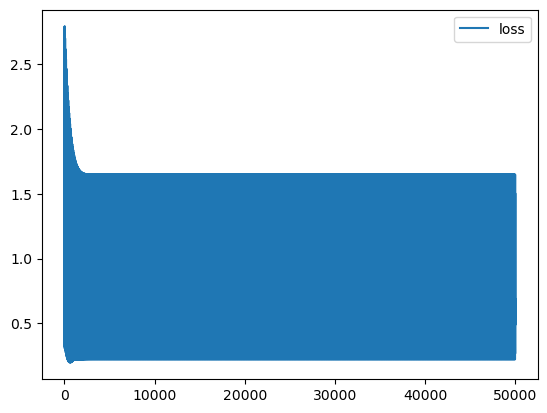

[ Info: Epoch 1: train step: 0, loss: 1.644980262638369
[ Info: Epoch 11: train step: 500, loss: 1.3758943354593771
[ Info: Epoch 21: train step: 1000, loss: 1.270760789455006
[ Info: Epoch 31: train step: 1500, loss: 1.246060799592207
[ Info: Epoch 41: train step: 2000, loss: 1.2488383095816773
[ Info: Epoch 51: train step: 2500, loss: 1.2545576837441235
[ Info: Epoch 61: train step: 3000, loss: 1.257540813579101
[ Info: Epoch 71: train step: 3500, loss: 1.2585901289871888
[ Info: Epoch 81: train step: 4000, loss: 1.2588847088870951
[ Info: Epoch 91: train step: 4500, loss: 1.258954839200857
[ Info: Epoch 101: train step: 5000, loss: 1.2589685209436507
[ Info: Epoch 111: train step: 5500, loss: 1.2589699462196509
[ Info: Epoch 121: train step: 6000, loss: 1.2589692476050194
[ Info: Epoch 131: train step: 6500, loss: 1.258968478958189
[ Info: Epoch 141: train step: 7000, loss: 1.2589679252927586
[ Info: Epoch 151: train step: 7500, loss: 1.2589675829605185
[ Info: Epoch 161: train step

[ Info: Epoch 841: train step: 42000, loss: 1.25896706202277
[ Info: Epoch 851: train step: 42500, loss: 1.2589670622196718
[ Info: Epoch 861: train step: 43000, loss: 1.2589670621540379
[ Info: Epoch 871: train step: 43500, loss: 1.2589670620884041
[ Info: Epoch 881: train step: 44000, loss: 1.25896706202277
[ Info: Epoch 891: train step: 44500, loss: 1.2589670622196718
[ Info: Epoch 901: train step: 45000, loss: 1.2589670621540379
[ Info: Epoch 911: train step: 45500, loss: 1.2589670620884041
[ Info: Epoch 921: train step: 46000, loss: 1.25896706202277
[ Info: Epoch 931: train step: 46500, loss: 1.2589670622196718
[ Info: Epoch 941: train step: 47000, loss: 1.2589670621540379
[ Info: Epoch 951: train step: 47500, loss: 1.2589670620884041
[ Info: Epoch 961: train step: 48000, loss: 1.25896706202277
[ Info: Epoch 971: train step: 48500, loss: 1.2589670622196718
[ Info: Epoch 981: train step: 49000, loss: 1.2589670621540379
[ Info: Epoch 991: train step: 49500, loss: 1.2589670620884041


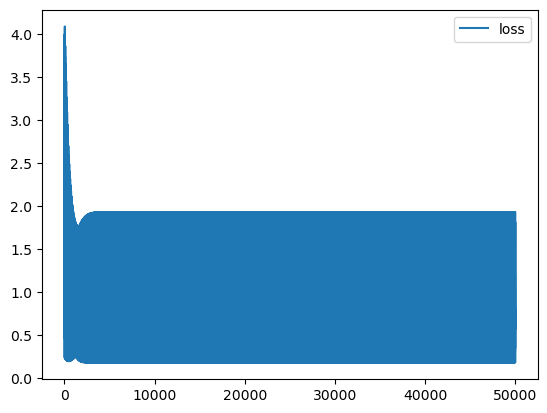

[ Info: Epoch 1: train step: 0, loss: 2.185736379482875
[ Info: Epoch 11: train step: 500, loss: 1.6795369223525909
[ Info: Epoch 21: train step: 1000, loss: 1.3630170116256959
[ Info: Epoch 31: train step: 1500, loss: 1.1805630612386397
[ Info: Epoch 41: train step: 2000, loss: 1.0886920940492157
[ Info: Epoch 51: train step: 2500, loss: 1.0514299440400432
[ Info: Epoch 61: train step: 3000, loss: 1.0412628620585407
[ Info: Epoch 71: train step: 3500, loss: 1.0407900875714011
[ Info: Epoch 81: train step: 4000, loss: 1.0420367290510864
[ Info: Epoch 91: train step: 4500, loss: 1.0428468432747737
[ Info: Epoch 101: train step: 5000, loss: 1.0431764531835854
[ Info: Epoch 111: train step: 5500, loss: 1.0432827326706025
[ Info: Epoch 121: train step: 6000, loss: 1.043311832514313
[ Info: Epoch 131: train step: 6500, loss: 1.0433184543243215
[ Info: Epoch 141: train step: 7000, loss: 1.0433193593329433
[ Info: Epoch 151: train step: 7500, loss: 1.0433191137308213
[ Info: Epoch 161: train 

[ Info: Epoch 881: train step: 44000, loss: 1.04331797301909
[ Info: Epoch 891: train step: 44500, loss: 1.0433179729651312
[ Info: Epoch 901: train step: 45000, loss: 1.0433179729831175
[ Info: Epoch 911: train step: 45500, loss: 1.04331797301909
[ Info: Epoch 921: train step: 46000, loss: 1.0433179729651312
[ Info: Epoch 931: train step: 46500, loss: 1.0433179729831175
[ Info: Epoch 941: train step: 47000, loss: 1.04331797301909
[ Info: Epoch 951: train step: 47500, loss: 1.0433179729651312
[ Info: Epoch 961: train step: 48000, loss: 1.0433179729831175
[ Info: Epoch 971: train step: 48500, loss: 1.04331797301909
[ Info: Epoch 981: train step: 49000, loss: 1.0433179729651312
[ Info: Epoch 991: train step: 49500, loss: 1.0433179729831175


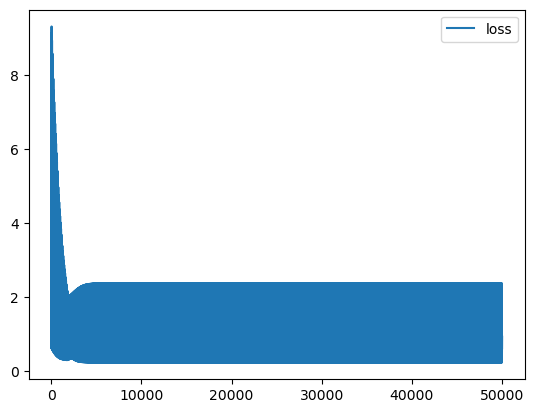

[ Info: Epoch 1: train step: 0, loss: 1.0724601156960745
[ Info: Epoch 11: train step: 500, loss: 0.9401401956629549
[ Info: Epoch 21: train step: 1000, loss: 0.8975857223769204
[ Info: Epoch 31: train step: 1500, loss: 0.8866402411437886
[ Info: Epoch 41: train step: 2000, loss: 0.8840837494787464
[ Info: Epoch 51: train step: 2500, loss: 0.8834515547282674
[ Info: Epoch 61: train step: 3000, loss: 0.8832834539917702
[ Info: Epoch 71: train step: 3500, loss: 0.8832379848130808
[ Info: Epoch 81: train step: 4000, loss: 0.8832257977050082
[ Info: Epoch 91: train step: 4500, loss: 0.8832225454617302
[ Info: Epoch 101: train step: 5000, loss: 0.883221642405464
[ Info: Epoch 111: train step: 5500, loss: 0.8832213864410645
[ Info: Epoch 121: train step: 6000, loss: 0.8832212901584209
[ Info: Epoch 131: train step: 6500, loss: 0.8832212485445037
[ Info: Epoch 141: train step: 7000, loss: 0.8832212290317069
[ Info: Epoch 151: train step: 7500, loss: 0.8832212272586666
[ Info: Epoch 161: train

[ Info: Epoch 861: train step: 43000, loss: 0.8832212177999574
[ Info: Epoch 871: train step: 43500, loss: 0.8832212177999574
[ Info: Epoch 881: train step: 44000, loss: 0.8832212177999574
[ Info: Epoch 891: train step: 44500, loss: 0.8832212177999574
[ Info: Epoch 901: train step: 45000, loss: 0.8832212177999574
[ Info: Epoch 911: train step: 45500, loss: 0.8832212177999574
[ Info: Epoch 921: train step: 46000, loss: 0.8832212177999574
[ Info: Epoch 931: train step: 46500, loss: 0.8832212177999574
[ Info: Epoch 941: train step: 47000, loss: 0.8832212177999574
[ Info: Epoch 951: train step: 47500, loss: 0.8832212177999574
[ Info: Epoch 961: train step: 48000, loss: 0.8832212177999574
[ Info: Epoch 971: train step: 48500, loss: 0.8832212177999574
[ Info: Epoch 981: train step: 49000, loss: 0.8832212177999574
[ Info: Epoch 991: train step: 49500, loss: 0.8832212177999574


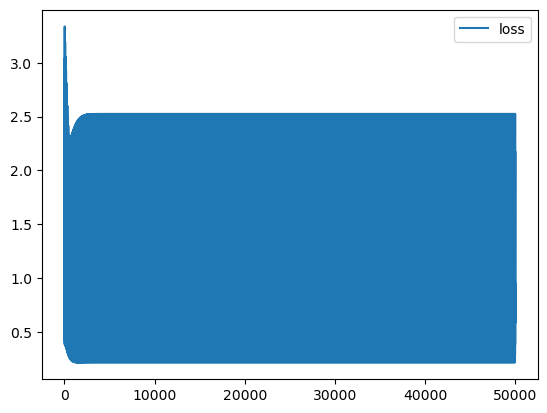

[ Info: Epoch 1: train step: 0, loss: 1.9204815829860546
[ Info: Epoch 11: train step: 500, loss: 1.4372558783503462
[ Info: Epoch 21: train step: 1000, loss: 1.1373120288752503
[ Info: Epoch 31: train step: 1500, loss: 0.9646313868498602
[ Info: Epoch 41: train step: 2000, loss: 0.8772568875861341
[ Info: Epoch 51: train step: 2500, loss: 0.841077268588972
[ Info: Epoch 61: train step: 3000, loss: 0.830479866876637
[ Info: Epoch 71: train step: 3500, loss: 0.8293932275208297
[ Info: Epoch 81: train step: 4000, loss: 0.830305237690672
[ Info: Epoch 91: train step: 4500, loss: 0.8310022551235171
[ Info: Epoch 101: train step: 5000, loss: 0.8313066831792353
[ Info: Epoch 111: train step: 5500, loss: 0.8314103545089777
[ Info: Epoch 121: train step: 6000, loss: 0.8314404152902215
[ Info: Epoch 131: train step: 6500, loss: 0.8314478952684766
[ Info: Epoch 141: train step: 7000, loss: 0.8314492695928019
[ Info: Epoch 151: train step: 7500, loss: 0.8314492403906575
[ Info: Epoch 161: train s

[ Info: Epoch 841: train step: 42000, loss: 0.8314483925319494
[ Info: Epoch 851: train step: 42500, loss: 0.8314483925319494
[ Info: Epoch 861: train step: 43000, loss: 0.8314483925319494
[ Info: Epoch 871: train step: 43500, loss: 0.8314483925319494
[ Info: Epoch 881: train step: 44000, loss: 0.8314483925319494
[ Info: Epoch 891: train step: 44500, loss: 0.8314483925319494
[ Info: Epoch 901: train step: 45000, loss: 0.8314483925319494
[ Info: Epoch 911: train step: 45500, loss: 0.8314483925319494
[ Info: Epoch 921: train step: 46000, loss: 0.8314483925319494
[ Info: Epoch 931: train step: 46500, loss: 0.8314483925319494
[ Info: Epoch 941: train step: 47000, loss: 0.8314483925319494
[ Info: Epoch 951: train step: 47500, loss: 0.8314483925319494
[ Info: Epoch 961: train step: 48000, loss: 0.8314483925319494
[ Info: Epoch 971: train step: 48500, loss: 0.8314483925319494
[ Info: Epoch 981: train step: 49000, loss: 0.8314483925319494
[ Info: Epoch 991: train step: 49500, loss: 0.831448392

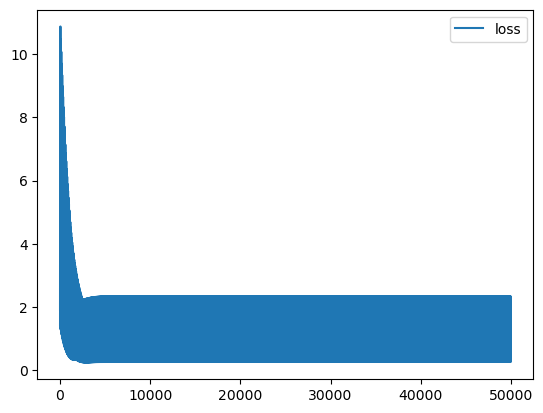

[ Info: Epoch 1: train step: 0, loss: 1.8472097311566968
[ Info: Epoch 11: train step: 500, loss: 1.3420566245923236
[ Info: Epoch 21: train step: 1000, loss: 1.0734749128421428
[ Info: Epoch 31: train step: 1500, loss: 0.9508937987374002
[ Info: Epoch 41: train step: 2000, loss: 0.9106315539334421
[ Info: Epoch 51: train step: 2500, loss: 0.9069335283474469
[ Info: Epoch 61: train step: 3000, loss: 0.9129969273778167
[ Info: Epoch 71: train step: 3500, loss: 0.9181127979385696
[ Info: Epoch 81: train step: 4000, loss: 0.9206193382196055
[ Info: Epoch 91: train step: 4500, loss: 0.9215464724589658
[ Info: Epoch 101: train step: 5000, loss: 0.921830486743836
[ Info: Epoch 111: train step: 5500, loss: 0.9219057091360258
[ Info: Epoch 121: train step: 6000, loss: 0.9219227727818294
[ Info: Epoch 131: train step: 6500, loss: 0.9219255917892746
[ Info: Epoch 141: train step: 7000, loss: 0.9219253939172699
[ Info: Epoch 151: train step: 7500, loss: 0.9219248384500418
[ Info: Epoch 161: train

[ Info: Epoch 841: train step: 42000, loss: 0.9219236121941595
[ Info: Epoch 851: train step: 42500, loss: 0.9219236121941595
[ Info: Epoch 861: train step: 43000, loss: 0.9219236121941595
[ Info: Epoch 871: train step: 43500, loss: 0.9219236121941595
[ Info: Epoch 881: train step: 44000, loss: 0.9219236121941595
[ Info: Epoch 891: train step: 44500, loss: 0.9219236121941595
[ Info: Epoch 901: train step: 45000, loss: 0.9219236121941595
[ Info: Epoch 911: train step: 45500, loss: 0.9219236121941595
[ Info: Epoch 921: train step: 46000, loss: 0.9219236121941595
[ Info: Epoch 931: train step: 46500, loss: 0.9219236121941595
[ Info: Epoch 941: train step: 47000, loss: 0.9219236121941595
[ Info: Epoch 951: train step: 47500, loss: 0.9219236121941595
[ Info: Epoch 961: train step: 48000, loss: 0.9219236121941595
[ Info: Epoch 971: train step: 48500, loss: 0.9219236121941595
[ Info: Epoch 981: train step: 49000, loss: 0.9219236121941595
[ Info: Epoch 991: train step: 49500, loss: 0.921923612

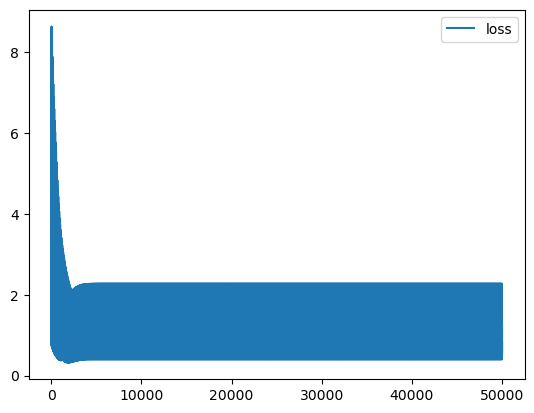

[ Info: Epoch 1: train step: 0, loss: 1.2737783111647372
[ Info: Epoch 11: train step: 500, loss: 1.0513235068029239
[ Info: Epoch 21: train step: 1000, loss: 0.9845001416520688
[ Info: Epoch 31: train step: 1500, loss: 0.9805241725097321
[ Info: Epoch 41: train step: 2000, loss: 0.9905503772614754
[ Info: Epoch 51: train step: 2500, loss: 0.9976531744697574
[ Info: Epoch 61: train step: 3000, loss: 1.0006410434864879
[ Info: Epoch 71: train step: 3500, loss: 1.001598583288736
[ Info: Epoch 81: train step: 4000, loss: 1.0018549222484374
[ Info: Epoch 91: train step: 4500, loss: 1.0019139124214775
[ Info: Epoch 101: train step: 5000, loss: 1.0019247600878232
[ Info: Epoch 111: train step: 5500, loss: 1.0019254163926021
[ Info: Epoch 121: train step: 6000, loss: 1.0019244821240103
[ Info: Epoch 131: train step: 6500, loss: 1.0019236182268951
[ Info: Epoch 141: train step: 7000, loss: 1.0019230243456154
[ Info: Epoch 151: train step: 7500, loss: 1.0019226503547862
[ Info: Epoch 161: train

[ Info: Epoch 841: train step: 42000, loss: 1.0019220773456259
[ Info: Epoch 851: train step: 42500, loss: 1.0019220773456259
[ Info: Epoch 861: train step: 43000, loss: 1.0019220773456259
[ Info: Epoch 871: train step: 43500, loss: 1.0019220773456259
[ Info: Epoch 881: train step: 44000, loss: 1.0019220773456259
[ Info: Epoch 891: train step: 44500, loss: 1.0019220773456259
[ Info: Epoch 901: train step: 45000, loss: 1.0019220773456259
[ Info: Epoch 911: train step: 45500, loss: 1.0019220773456259
[ Info: Epoch 921: train step: 46000, loss: 1.0019220773456259
[ Info: Epoch 931: train step: 46500, loss: 1.0019220773456259
[ Info: Epoch 941: train step: 47000, loss: 1.0019220773456259
[ Info: Epoch 951: train step: 47500, loss: 1.0019220773456259
[ Info: Epoch 961: train step: 48000, loss: 1.0019220773456259
[ Info: Epoch 971: train step: 48500, loss: 1.0019220773456259
[ Info: Epoch 981: train step: 49000, loss: 1.0019220773456259
[ Info: Epoch 991: train step: 49500, loss: 1.001922077

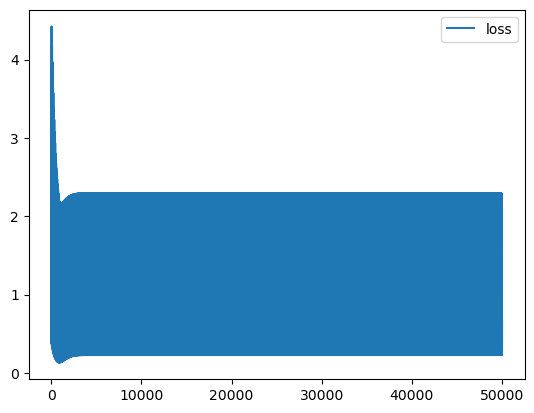

[ Info: Epoch 1: train step: 0, loss: 0.6644702518470189
[ Info: Epoch 11: train step: 500, loss: 0.6754551244347049
[ Info: Epoch 21: train step: 1000, loss: 0.6785919019939198
[ Info: Epoch 31: train step: 1500, loss: 0.6792993717762935
[ Info: Epoch 41: train step: 2000, loss: 0.679450788173414
[ Info: Epoch 51: train step: 2500, loss: 0.6794824411186642
[ Info: Epoch 61: train step: 3000, loss: 0.6794888434371308
[ Info: Epoch 71: train step: 3500, loss: 0.6794900282069016
[ Info: Epoch 81: train step: 4000, loss: 0.6794901805857917
[ Info: Epoch 91: train step: 4500, loss: 0.6794901553031527
[ Info: Epoch 101: train step: 5000, loss: 0.6794901154456016
[ Info: Epoch 111: train step: 5500, loss: 0.6794900851114112
[ Info: Epoch 121: train step: 6000, loss: 0.6794900658737622
[ Info: Epoch 131: train step: 6500, loss: 0.679490055400011
[ Info: Epoch 141: train step: 7000, loss: 0.6794900473543268
[ Info: Epoch 151: train step: 7500, loss: 0.6794900421734955
[ Info: Epoch 161: train 

[ Info: Epoch 861: train step: 43000, loss: 0.679490031550715
[ Info: Epoch 871: train step: 43500, loss: 0.679490031550715
[ Info: Epoch 881: train step: 44000, loss: 0.679490031550715
[ Info: Epoch 891: train step: 44500, loss: 0.679490031550715
[ Info: Epoch 901: train step: 45000, loss: 0.679490031550715
[ Info: Epoch 911: train step: 45500, loss: 0.679490031550715
[ Info: Epoch 921: train step: 46000, loss: 0.679490031550715
[ Info: Epoch 931: train step: 46500, loss: 0.679490031550715
[ Info: Epoch 941: train step: 47000, loss: 0.679490031550715
[ Info: Epoch 951: train step: 47500, loss: 0.679490031550715
[ Info: Epoch 961: train step: 48000, loss: 0.679490031550715
[ Info: Epoch 971: train step: 48500, loss: 0.679490031550715
[ Info: Epoch 981: train step: 49000, loss: 0.679490031550715
[ Info: Epoch 991: train step: 49500, loss: 0.679490031550715


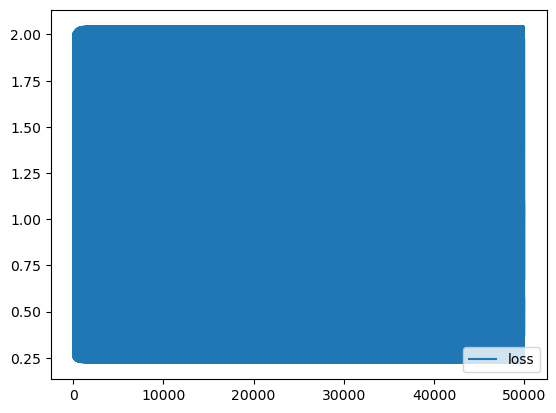

[ Info: Epoch 1: train step: 0, loss: 0.6318343853029426
[ Info: Epoch 11: train step: 500, loss: 0.37150845917432496
[ Info: Epoch 21: train step: 1000, loss: 0.29757625930968334
[ Info: Epoch 31: train step: 1500, loss: 0.305931012716962
[ Info: Epoch 41: train step: 2000, loss: 0.3322457554138529
[ Info: Epoch 51: train step: 2500, loss: 0.3503122628962474
[ Info: Epoch 61: train step: 3000, loss: 0.35826377800869647
[ Info: Epoch 71: train step: 3500, loss: 0.36091057562349665
[ Info: Epoch 81: train step: 4000, loss: 0.36163240571763294
[ Info: Epoch 91: train step: 4500, loss: 0.3617996815186719
[ Info: Epoch 101: train step: 5000, loss: 0.36183134450461607
[ Info: Epoch 111: train step: 5500, loss: 0.36183438727538103
[ Info: Epoch 121: train step: 6000, loss: 0.3618327162034721
[ Info: Epoch 131: train step: 6500, loss: 0.36183095074411276
[ Info: Epoch 141: train step: 7000, loss: 0.3618297346507157
[ Info: Epoch 151: train step: 7500, loss: 0.3618289772690269
[ Info: Epoch 16

[ Info: Epoch 881: train step: 44000, loss: 0.36182775568619563
[ Info: Epoch 891: train step: 44500, loss: 0.36182775568619563
[ Info: Epoch 901: train step: 45000, loss: 0.36182775568619563
[ Info: Epoch 911: train step: 45500, loss: 0.36182775568619563
[ Info: Epoch 921: train step: 46000, loss: 0.36182775568619563
[ Info: Epoch 931: train step: 46500, loss: 0.36182775568619563
[ Info: Epoch 941: train step: 47000, loss: 0.36182775568619563
[ Info: Epoch 951: train step: 47500, loss: 0.36182775568619563
[ Info: Epoch 961: train step: 48000, loss: 0.36182775568619563
[ Info: Epoch 971: train step: 48500, loss: 0.36182775568619563
[ Info: Epoch 981: train step: 49000, loss: 0.36182775568619563
[ Info: Epoch 991: train step: 49500, loss: 0.36182775568619563


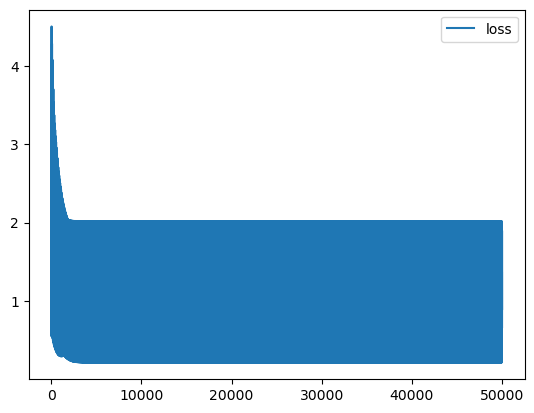

[ Info: Epoch 1: train step: 0, loss: 3.0292264481191027
[ Info: Epoch 11: train step: 500, loss: 1.9851664347620595
[ Info: Epoch 21: train step: 1000, loss: 1.2735200060200877
[ Info: Epoch 31: train step: 1500, loss: 0.8045326225480027
[ Info: Epoch 41: train step: 2000, loss: 0.5147392930298003
[ Info: Epoch 51: train step: 2500, loss: 0.3501600071254168
[ Info: Epoch 61: train step: 3000, loss: 0.2656779983578888
[ Info: Epoch 71: train step: 3500, loss: 0.22664629729539562
[ Info: Epoch 81: train step: 4000, loss: 0.21019265462434925
[ Info: Epoch 91: train step: 4500, loss: 0.20376644342603784
[ Info: Epoch 101: train step: 5000, loss: 0.20146033716544345
[ Info: Epoch 111: train step: 5500, loss: 0.20071624180054629
[ Info: Epoch 121: train step: 6000, loss: 0.2005006803061704
[ Info: Epoch 131: train step: 6500, loss: 0.20044253829526393
[ Info: Epoch 141: train step: 7000, loss: 0.20042672624181787
[ Info: Epoch 151: train step: 7500, loss: 0.20042177196575364
[ Info: Epoch 1

[ Info: Epoch 841: train step: 42000, loss: 0.2004174218950717
[ Info: Epoch 851: train step: 42500, loss: 0.20041742192265105
[ Info: Epoch 861: train step: 43000, loss: 0.2004174213434844
[ Info: Epoch 871: train step: 43500, loss: 0.20041742217086536
[ Info: Epoch 881: train step: 44000, loss: 0.20041742159169867
[ Info: Epoch 891: train step: 44500, loss: 0.2004174221157066
[ Info: Epoch 901: train step: 45000, loss: 0.20041742183991298
[ Info: Epoch 911: train step: 45500, loss: 0.20041742145380187
[ Info: Epoch 921: train step: 46000, loss: 0.20041742208812727
[ Info: Epoch 931: train step: 46500, loss: 0.2004174215089606
[ Info: Epoch 941: train step: 47000, loss: 0.20041742233634152
[ Info: Epoch 951: train step: 47500, loss: 0.20041742175717486
[ Info: Epoch 961: train step: 48000, loss: 0.20041742167443677
[ Info: Epoch 971: train step: 48500, loss: 0.2004174220053892
[ Info: Epoch 981: train step: 49000, loss: 0.20041742142622251
[ Info: Epoch 991: train step: 49500, loss: 0

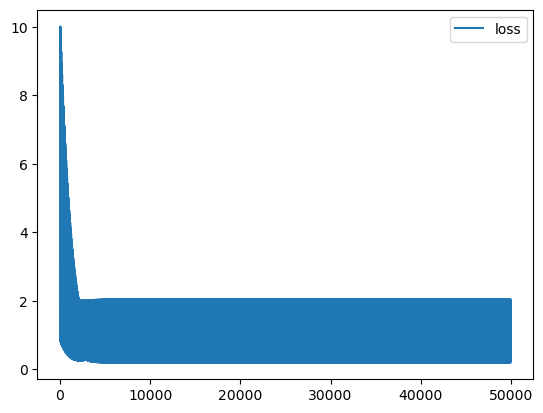

[ Info: Epoch 1: train step: 0, loss: 0.755021182419965
[ Info: Epoch 11: train step: 500, loss: 0.44038643574164266
[ Info: Epoch 21: train step: 1000, loss: 0.333366808845724
[ Info: Epoch 31: train step: 1500, loss: 0.3092476253965487
[ Info: Epoch 41: train step: 2000, loss: 0.3068117605598192
[ Info: Epoch 51: train step: 2500, loss: 0.307267832784448
[ Info: Epoch 61: train step: 3000, loss: 0.3075674281598422
[ Info: Epoch 71: train step: 3500, loss: 0.30766531757251403
[ Info: Epoch 81: train step: 4000, loss: 0.30769139642278237
[ Info: Epoch 91: train step: 4500, loss: 0.3076975517870576
[ Info: Epoch 101: train step: 5000, loss: 0.30769876943544616
[ Info: Epoch 111: train step: 5500, loss: 0.3076988617057329
[ Info: Epoch 121: train step: 6000, loss: 0.30769877573606663
[ Info: Epoch 131: train step: 6500, loss: 0.30769868489864555
[ Info: Epoch 141: train step: 7000, loss: 0.3076986156850864
[ Info: Epoch 151: train step: 7500, loss: 0.30769858716977605
[ Info: Epoch 161: 

[ Info: Epoch 841: train step: 42000, loss: 0.3076985179673174
[ Info: Epoch 851: train step: 42500, loss: 0.3076985179673174
[ Info: Epoch 861: train step: 43000, loss: 0.3076985179673174
[ Info: Epoch 871: train step: 43500, loss: 0.3076985179673174
[ Info: Epoch 881: train step: 44000, loss: 0.3076985179673174
[ Info: Epoch 891: train step: 44500, loss: 0.3076985179673174
[ Info: Epoch 901: train step: 45000, loss: 0.3076985179673174
[ Info: Epoch 911: train step: 45500, loss: 0.3076985179673174
[ Info: Epoch 921: train step: 46000, loss: 0.3076985179673174
[ Info: Epoch 931: train step: 46500, loss: 0.3076985179673174
[ Info: Epoch 941: train step: 47000, loss: 0.3076985179673174
[ Info: Epoch 951: train step: 47500, loss: 0.3076985179673174
[ Info: Epoch 961: train step: 48000, loss: 0.3076985179673174
[ Info: Epoch 971: train step: 48500, loss: 0.3076985179673174
[ Info: Epoch 981: train step: 49000, loss: 0.3076985179673174
[ Info: Epoch 991: train step: 49500, loss: 0.307698517

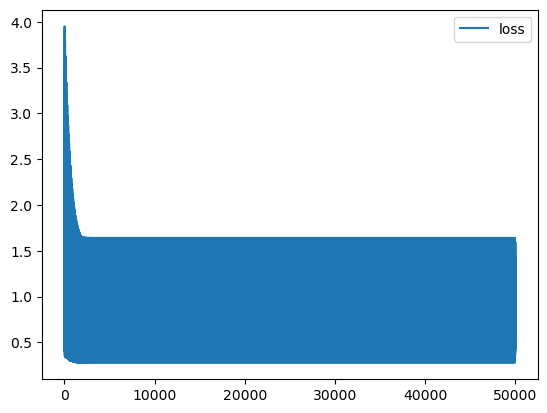

[ Info: Epoch 1: train step: 0, loss: 0.8053785929942967
[ Info: Epoch 11: train step: 500, loss: 0.5860809528363589
[ Info: Epoch 21: train step: 1000, loss: 0.5397571196456471
[ Info: Epoch 31: train step: 1500, loss: 0.5340792614296254
[ Info: Epoch 41: train step: 2000, loss: 0.5339263295008438
[ Info: Epoch 51: train step: 2500, loss: 0.5340437303957601
[ Info: Epoch 61: train step: 3000, loss: 0.5340865159614386
[ Info: Epoch 71: train step: 3500, loss: 0.5340979256637344
[ Info: Epoch 81: train step: 4000, loss: 0.5341007496096142
[ Info: Epoch 91: train step: 4500, loss: 0.5341014287167386
[ Info: Epoch 101: train step: 5000, loss: 0.534101609850072
[ Info: Epoch 111: train step: 5500, loss: 0.5341016567941781
[ Info: Epoch 121: train step: 6000, loss: 0.5341016749142861
[ Info: Epoch 131: train step: 6500, loss: 0.5341016832266029
[ Info: Epoch 141: train step: 7000, loss: 0.5341016908790668
[ Info: Epoch 151: train step: 7500, loss: 0.5341016885131189
[ Info: Epoch 161: train

[ Info: Epoch 841: train step: 42000, loss: 0.5341016838104291
[ Info: Epoch 851: train step: 42500, loss: 0.5341016838104291
[ Info: Epoch 861: train step: 43000, loss: 0.5341016838104291
[ Info: Epoch 871: train step: 43500, loss: 0.5341016838104291
[ Info: Epoch 881: train step: 44000, loss: 0.5341016838104291
[ Info: Epoch 891: train step: 44500, loss: 0.5341016838104291
[ Info: Epoch 901: train step: 45000, loss: 0.5341016838104291
[ Info: Epoch 911: train step: 45500, loss: 0.5341016838104291
[ Info: Epoch 921: train step: 46000, loss: 0.5341016838104291
[ Info: Epoch 931: train step: 46500, loss: 0.5341016838104291
[ Info: Epoch 941: train step: 47000, loss: 0.5341016838104291
[ Info: Epoch 951: train step: 47500, loss: 0.5341016838104291
[ Info: Epoch 961: train step: 48000, loss: 0.5341016838104291
[ Info: Epoch 971: train step: 48500, loss: 0.5341016838104291
[ Info: Epoch 981: train step: 49000, loss: 0.5341016838104291
[ Info: Epoch 991: train step: 49500, loss: 0.534101683

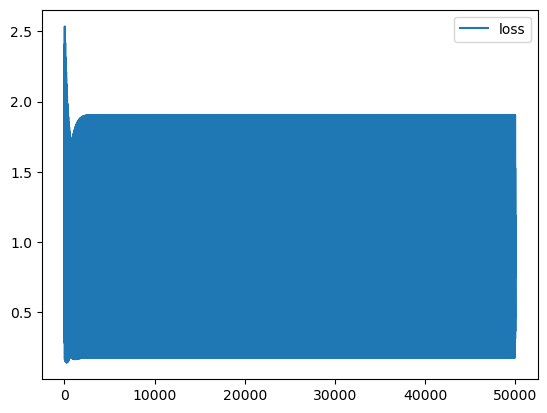

[ Info: Epoch 1: train step: 0, loss: 2.624467201755566
[ Info: Epoch 11: train step: 500, loss: 1.764558571641069
[ Info: Epoch 21: train step: 1000, loss: 1.2246794393114877
[ Info: Epoch 31: train step: 1500, loss: 0.9041207190335742
[ Info: Epoch 41: train step: 2000, loss: 0.7323228887089068
[ Info: Epoch 51: train step: 2500, loss: 0.6516544013248986
[ Info: Epoch 61: train step: 3000, loss: 0.6190017122410139
[ Info: Epoch 71: train step: 3500, loss: 0.6073794539986962
[ Info: Epoch 81: train step: 4000, loss: 0.6035257316754266
[ Info: Epoch 91: train step: 4500, loss: 0.6022840562613337
[ Info: Epoch 101: train step: 5000, loss: 0.6018995898175139
[ Info: Epoch 111: train step: 5500, loss: 0.6017872297449791
[ Info: Epoch 121: train step: 6000, loss: 0.6017555409136154
[ Info: Epoch 131: train step: 6500, loss: 0.601746285117339
[ Info: Epoch 141: train step: 7000, loss: 0.6017431643494475
[ Info: Epoch 151: train step: 7500, loss: 0.6017418611195997
[ Info: Epoch 161: train s

[ Info: Epoch 861: train step: 43000, loss: 0.6017402241724092
[ Info: Epoch 871: train step: 43500, loss: 0.6017402242278292
[ Info: Epoch 881: train step: 44000, loss: 0.6017402241724092
[ Info: Epoch 891: train step: 44500, loss: 0.6017402242278292
[ Info: Epoch 901: train step: 45000, loss: 0.6017402241724092
[ Info: Epoch 911: train step: 45500, loss: 0.6017402242278292
[ Info: Epoch 921: train step: 46000, loss: 0.6017402241724092
[ Info: Epoch 931: train step: 46500, loss: 0.6017402242278292
[ Info: Epoch 941: train step: 47000, loss: 0.6017402241724092
[ Info: Epoch 951: train step: 47500, loss: 0.6017402242278292
[ Info: Epoch 961: train step: 48000, loss: 0.6017402241724092
[ Info: Epoch 971: train step: 48500, loss: 0.6017402242278292
[ Info: Epoch 981: train step: 49000, loss: 0.6017402241724092
[ Info: Epoch 991: train step: 49500, loss: 0.6017402242278292


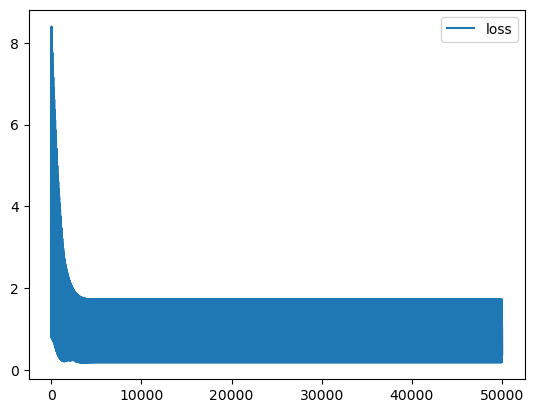

 93.455352 seconds (990.46 M allocations: 59.980 GiB, 8.80% gc time, 0.44% compilation time)


In [379]:
@time begin
    for t in 1:TVALS
        train_mlp!(net_tot[t], normalise(rr_data_train[t, :, 1], dims=1), normalise(re_data_train[t, :, 1], dims=1), hp )
        #train_mlp!(net_tot[t], rr_data_train[t, :, :], re_data_train[t, :, :], hp )

    end
end

In [380]:
net_tot[1](normalise(reshape(rr_data_test[1, :, 1:1], 1, 2000)))

1×2000 Matrix{Float64}:
 0.145035  0.202946  0.39543  0.195461  …  0.00534286  -0.206746  -0.099228

2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000


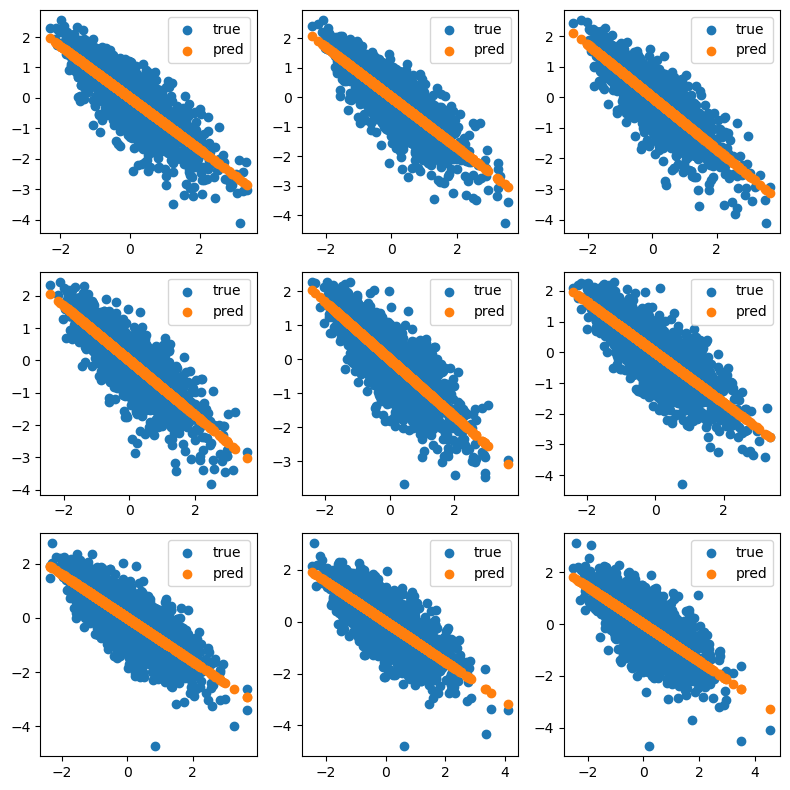

In [394]:

fig = figure(figsize=(8,8))
for k in 1:9
    TT = k+24
    ii = 330+k

    xxtest = normalise(rr_data_test[TT, :, 1:1], dims=1)
    #xxtest = rr_data_test[TT, :, 1:1]

    ypred = net_tot[TT](reshape(xxtest, 1, 1, 1, size(xxtest,1) ))
    ytrue = normalise(re_data_test[TT,:, 1:1], dims=1)
    #ytrue = re_data_test[TT,:, 1:1]
    #println(length(ytrue))
    #println(length(ypred))


    subplot(ii)
    scatter(xxtest[:,1], ytrue[:,1], label="true")
    scatter(xxtest[:,1], ypred[1,1,1,:], label="pred")
    legend()
end
tight_layout()
display(gcf())
close("all")

In [401]:
re_predicted = Array{Float64}(undef, TVALS, 2000, 1)

for TT in 1:TVALS
    
    xxtest = normalise(rr_data_test[TT, :, 1:1],dims=1)
    #xxtest = rr_data_test[TT, :, 1:1]

    ypred = permutedims(dropdims(net_tot[TT](reshape(xxtest, 1, 1, 1, size(xxtest,1) )), dims=(1,2)))
    ypred = ypred .* std_re_test[TT, :, 1:1] .+ mean_re_test[TT, :, 1:1]
    re_predicted[TT,:,:] = ypred
    ytrue = re_data_test[TT,:, :]
end

In [419]:
rr_data_test[1,:,1]

2000-element Vector{Float64}:
 1.654758093690256
 1.657705247654514
 1.667500891451266
 1.657324333888366
 1.646153066803622
 1.65201432341112
 1.644995890223706
 1.643246676850277
 1.634210354197489
 1.643199970740403
 1.650410269219126
 1.648920499866469
 1.645710048680043
 ⋮
 1.632217735577002
 1.643942719275584
 1.636988698729825
 1.634046919133167
 1.646686300404589
 1.657986096078382
 1.650426899233408
 1.640210354593829
 1.647477079563182
 1.647649089663624
 1.636855758228118
 1.64232740883379

In [403]:
std(re_data_test[1,:,1])

0.0015760753267299902

In [404]:
corr_re_pred = corr_obs_rr(re_predicted, "predicted1");

tvals: 48
ncnfg: 2000
nsrcs: 1
(48, 2000)


In [405]:
corr_re_test = corr_obs_rr(re_data_test, "test1");

tvals: 48
ncnfg: 2000
nsrcs: 4
(48, 2000)


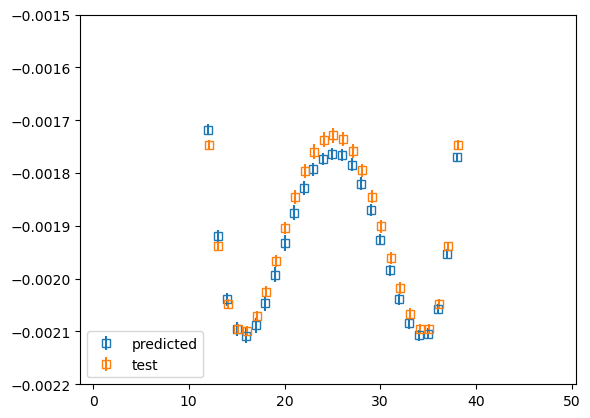

In [406]:
uwerr.(corr_re_pred)
uwerr.(corr_re_test)
xx = collect(1:length(corr_re_pred))

errorbar(xx, value.(corr_re_pred), err.(corr_re_pred), fmt="s", label="predicted", mfc="none")
errorbar(xx.+0.1, value.(corr_re_test), err.(corr_re_test), fmt="s", label="test", mfc="none")
ylim(-0.0022, -0.0015)
#xlim(20,30)
legend()
display(gcf())
close("all")

## Bias correction


tvals: 48
ncnfg: 500
nsrcs: 4
(48, 500)


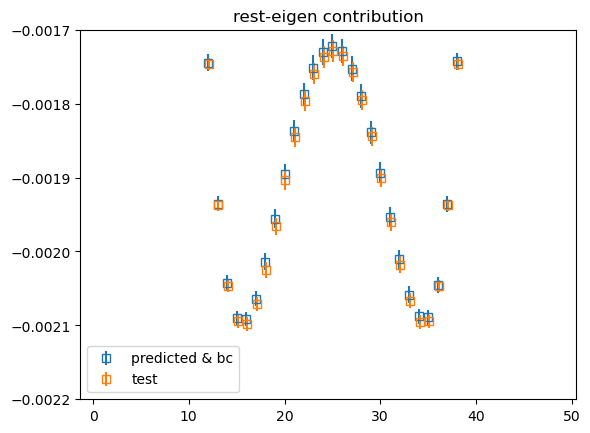

In [421]:
corr_re_bc = corr_obs_rr(re_data_train, "true_for_bc");
bc = corr_re_bc .- corr_re_pred

corr_re_pred_bc =corr_re_pred .+ bc

uwerr.(corr_re_pred_bc)
uwerr.(corr_re_test)
xx = collect(1:length(corr_re_pred_bc))

errorbar(xx, value.(corr_re_pred_bc), err.(corr_re_pred_bc), fmt="s", label="predicted & bc", mfc="none")
errorbar(xx.+0.1, value.(corr_re_test), err.(corr_re_test), fmt="s", label="test", mfc="none")
ylim(-0.0022, -0.0017)
#xlim(20,30)
title("rest-eigen contribution")
legend()
#savefig("/Users/alessandroconigli/Desktop/re_prediction_bc.pdf")
display(gcf())
close("all")

In [417]:
uwerr.(bc)
bc

48-element Vector{uwreal}:
 -0.00011277857509292728 +/- 4.768961883273991e-5
 -6.54396315277481e-5 +/- 5.008049622373059e-5
 -4.52017486909026e-5 +/- 4.374103053137168e-5
 -3.714446581584794e-5 +/- 3.2183505359193044e-5
 -2.5337586292676142e-5 +/- 2.2715413983783762e-5
 -2.799913515616481e-5 +/- 1.7881146358921145e-5
 -3.280095336796198e-5 +/- 1.8727664846870844e-5
 -3.8416066937206584e-5 +/- 1.7955059952560708e-5
 -4.31631934241996e-5 +/- 1.730084278132133e-5
 -4.19186303361554e-5 +/- 1.601625107604023e-5
 -3.665999653099236e-5 +/- 1.5534001794411676e-5
 -2.7227991423120794e-5 +/- 1.5197766391559985e-5
 -1.623274395709442e-5 +/- 1.568794876894807e-5
 ⋮
 1.8017165230161964e-5 +/- 1.4630570741842067e-5
 2.6887002170851134e-5 +/- 1.4016061798253466e-5
 3.5442560228411734e-5 +/- 1.4502788184478697e-5
 4.4688747428208494e-5 +/- 1.537769542017691e-5
 4.3669555500878564e-5 +/- 1.9947822680677698e-5
 3.899058890214656e-5 +/- 2.2552134476515352e-5
 2.4206210484587366e-5 +/- 2.490089929870418e-